In [223]:
# Importing Modules
from collections import Counter
import json
import time
import ast

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [224]:
# Reading the Health Care Charity Quick View Data
quick_view_df = pd.read_csv("full_features_clean_health_care_charities.csv", parse_dates=["0.Reporting Date", "1.Reporting Date", "2.Reporting Date", "3.Reporting Date", "4.Reporting Date"])

# Reading the Detailed Info of Charities from Advanced Search
info_df = pd.read_csv("health_care_charities.csv")
info_df.rename(columns = {'Address': 'address', 'registration_number': 'BN/Registration number', 'Category:': 'category', 'Charity name:': 'name', 'Charity status': 'status', 'Charity type:': 'type', 'City': 'city', 'Effective date of status': 'date_of_status', 'Postal code/Zip code': 'postal_code', 'Province, territory, outside of Canada:': 'province'}, inplace=True)

### Merging the two DataFrames

In [225]:
# On BN/Registration number
df = quick_view_df.merge(info_df, on="BN/Registration number")

### Manual Data Correction

In [226]:
# Fixing a few Incorrect Data Points
#   The Charities below used the value of the total compensation for all positions as their number of full time employees
df.loc[5526, "0.Full Time Employees"] = 3
df.loc[5526, "0.Part Time Employees"] = np.nan
df.loc[5526, "1.Full Time Employees"] = 2
df.loc[5526, "1.Part Time Employees"] = np.nan
df.loc[1851, "0.Full Time Employees"] = 1
df.loc[1851, "0.Part Time Employees"] = np.nan
df.loc[1851, "1.Full Time Employees"] = 2
df.loc[1851, "1.Part Time Employees"] = np.nan
# The data for this charity threw an odd error
df.loc[6149, "province"] = "ONTARIO"
df.loc[6149, "general_category"] = "Health Care"
df.loc[6149, "_id"] = "634aee1a7cf52bd240f90a95"

In [227]:
# Removing Charities that are not in Canada
#   Two in total: One is in Texas, the other in Great Britain
df.dropna(subset="province", inplace=True)

### Feature Creation

In [236]:
def get_govn_funding(df: pd.DataFrame, reporting_period_index: int):
    govn_fund_list = []
    column_name = f"{str(reporting_period_index)}.Revenue"
    for revenue in list(df[column_name]):
        if isinstance(revenue, float):
            govn_fund_list.append(revenue)
        else:
            first, second = revenue.split("'Government funding': ")
            value = second.split(",")[0]
            govn_fund_list.append(float(value))
    return govn_fund_list

# Creating Top Salary Index Column
def top_salary_indexes(df: pd.DataFrame, reporting_period_index: int):
    '''
    Input: the DataFrame with Salary Data, Reporting Period Index to analyze
    
    This function find the highest salary index for each salary array in the column SalaryArray.
    
    Output: An Array of the same length as the DataFrame, with the highest non-zero index in each Salary Array, or np.nan if all zeros
    '''
    top_salary_indexes = []
    column_name = f"{str(reporting_period_index)}.SalaryArray"
    salary_arrays = df[column_name].apply(ast.literal_eval)
    for salary_list in salary_arrays:
        for i in range(1,10):
            if salary_list == [0,0,0,0,0,0,0,0,0]:
                top_salary_indexes.append(np.nan)
                break
            if salary_list[-i] != 0:
                top_salary_indexes.append(9-i)
                break
    return top_salary_indexes

def salary_array_sum(df: pd.DataFrame, reporting_period_index: int):
    '''
    Input: the DataFrame with Salary Data, Reporting Period Index to analyze
    
    This function takes the sum of each Salary Array index.
    
    Output: An Array of Length 9, with the sum of each Salary Array index in the DataFrame for the specified reporting period
    '''
    sum_list = [0,0,0,0,0,0,0,0,0]
    column_name = f"{str(reporting_period_index)}.SalaryArray"
    salary_arrays = df[column_name].apply(ast.literal_eval)
    for salary_list in salary_arrays:
        for index, count in enumerate(salary_list):
            sum_list[index] += count
    return sum_list

salary_bin_labels = ["$1 to $39,999", "$40,000 to $79,999", "$80,000 to $119,999", "$120,000 to $159,999", "$160,000 to $199,999", "$200,000 to $249,999", "$250,000 to $299,999", "$300,000 to $349,999", "$350,000 and over"]

In [229]:
df["0.All Employees"] = df["0.Full Time Employees"] + df["0.Part Time Employees"] 
df["0.Average Salary"] = df["0.Total Compensation Value"] / df["0.All Employees"][df["0.All Employees"] != 0]
df["0.Percent Revenue to Compensation"] = (df["0.Total Compensation Value"] / df["0.Total Revenue"]) * 100
df["0.Ratio Compensation to Revenue"] = df["0.Total Compensation Value"] / df["0.Total Revenue"]
df["0.Ratio Compensation to Expenses"] = df["0.Total Compensation Value"] / df["0.Total Expenses"]
df["0.Ratio Part Time to Full Time"] = df["0.Part Time Employees"] / df["0.Full Time Employees"][df["0.Full Time Employees"] != 0]
df["0.Ratio Compensation to Revenue"] = df["0.Total Compensation Value"] / df["0.Total Revenue"]

df["0.Government Funding"] = get_govn_funding(df, 0)
df["0.Ratio Government Funding to Total Revenue"] = df["0.Government Funding"] / df["0.Total Revenue"]
df["0.Top Salary Index"] = top_salary_indexes(df, 0)

## Making each graph for report pretty perfect

(0.0, 2500000.0)

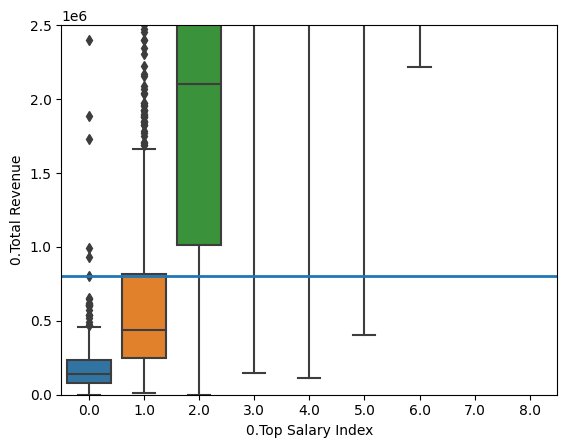

In [107]:
sns.boxplot(data=df, x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 8e5), slope=0, linewidth=2)
plt.ylim(0,2.5e6)

(0.0, 150000.0)

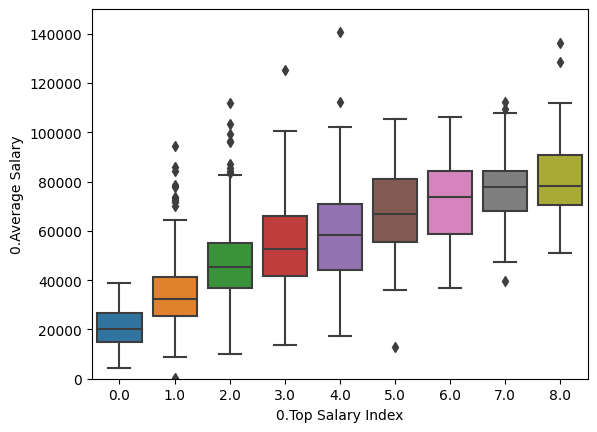

In [222]:
sns.boxplot(data=df[df["0.Ratio Part Time to Full Time"] < 1], x='0.Top Salary Index', y='0.Average Salary')
# plt.axline((0, 8.6e5), slope=0, linewidth=2)
plt.ylim(0,1.5e5)

## Testing New Similar Query

In [209]:
#similarity = df[(df["0.Ratio Part Time to Full Time"] < 1) & (df["0.Ratio Government Funding to Total Revenue"] == 0) & (df["0.Average Salary"] > 20000)]
#similarity = df[(df["0.Ratio Part Time to Full Time"] < 1) & (df["0.Total Revenue"].between(4.31e5, 1.293e6)) & (df["0.Average Salary"] > 20000)]
#similarity = df[(df["0.Ratio Part Time to Full Time"] < 1) & (df["0.Total Revenue"].between(6.46e5, 1.077e6)) & (df["0.Average Salary"] > 20000)]
#similarity = df[(df["0.Ratio Part Time to Full Time"] < 1) & (df["0.Total Revenue"].between(0, 1.723e6)) & (df["0.Average Salary"] > 20000)]
similarity = df[(df["0.Full Time Employees"].between(4, 8)) & (df["0.Total Revenue"].between(4.31e5, 1.293e6))]

In [210]:
similarity.shape

(230, 90)

In [211]:
similarity[similarity.city == "TORONTO"]["0.Top Salary Index"].median()

2.0

(0.0, 2000000.0)

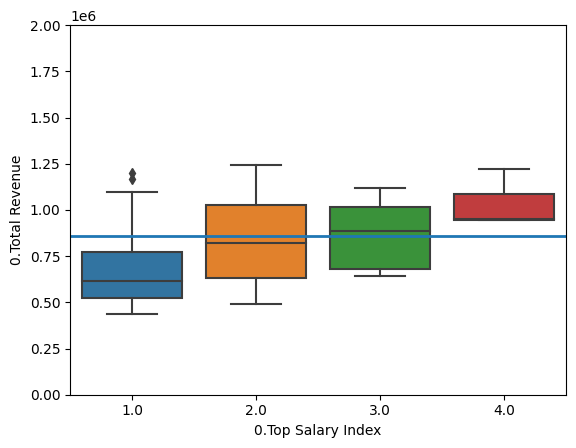

In [212]:
sns.boxplot(data=similarity, x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 8.6e5), slope=0, linewidth=2)
plt.ylim(0,2e6)

(0.0, 100000000.0)

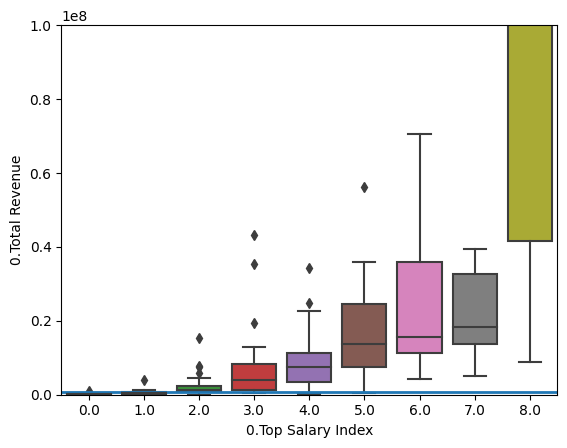

In [213]:
sns.boxplot(data=df[df.city == "TORONTO"], x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 8.6e5), slope=0, linewidth=2)
plt.ylim(0,1e8)

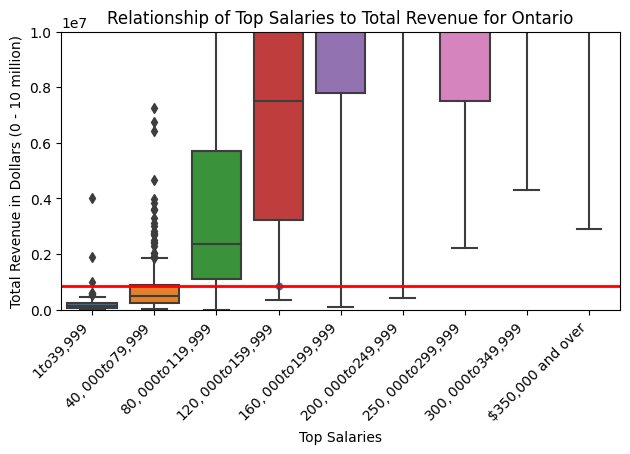

In [255]:
chart =sns.boxplot(data=df[df.province == "ONTARIO"], x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 8.6e5), slope=0, linewidth=2, color='red')
plt.ylim(0,1e7)
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue for Ontario")
plt.ylabel("Total Revenue in Dollars (0 - 10 million)")
plt.xlabel("Top Salaries")

chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

(0.0, 2500000.0)

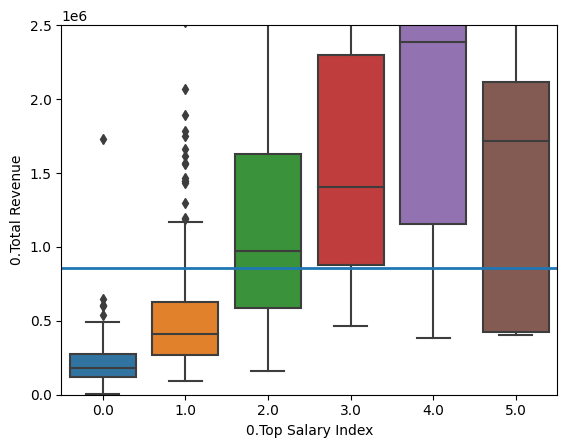

In [215]:
sns.boxplot(data=df[df["0.Full Time Employees"].between(2, 10)], x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 8.6e5), slope=0, linewidth=2)
plt.ylim(0,2.5e6)

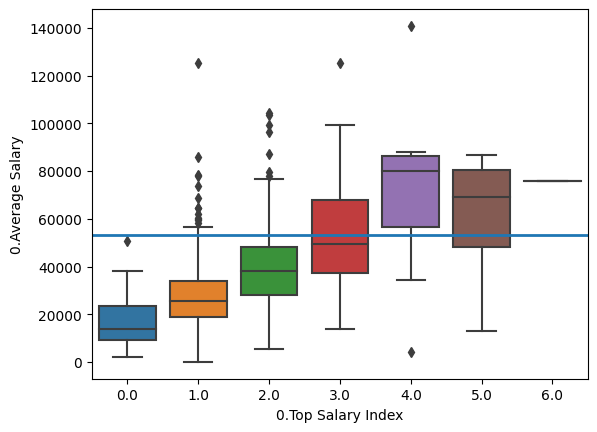

In [216]:
sns.boxplot(data=df[df["0.Total Revenue"].between(2.5e5, 2.5e6)], x='0.Top Salary Index', y='0.Average Salary')
plt.axline((0, 53000), slope=0, linewidth=2)
#plt.ylim(0,100000)

(0.0, 2000000.0)

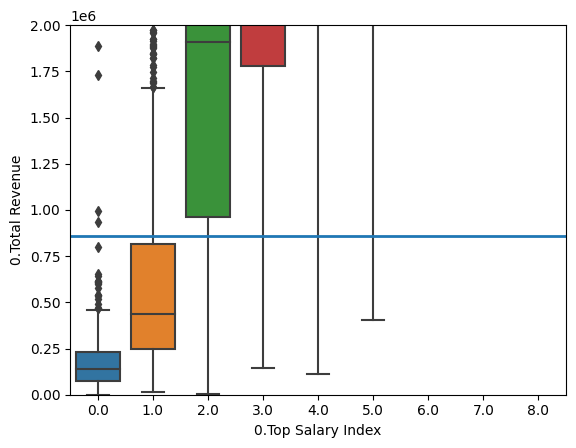

In [217]:
sns.boxplot(data=df[df["0.Total Revenue"] <= 1e7], x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 8.6e5), slope=0, linewidth=2)
plt.ylim(0,2e6)

(0.0, 10.0)

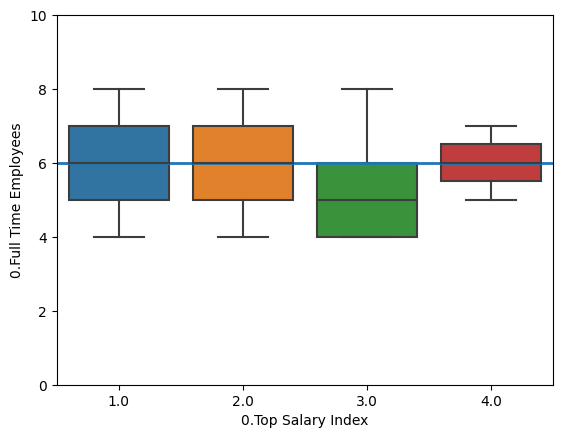

In [219]:
sns.boxplot(data=similarity, x='0.Top Salary Index', y='0.Full Time Employees')
plt.axline((0, 6), slope=0, linewidth=2)
plt.ylim(0,10)

(0.0, 100000.0)

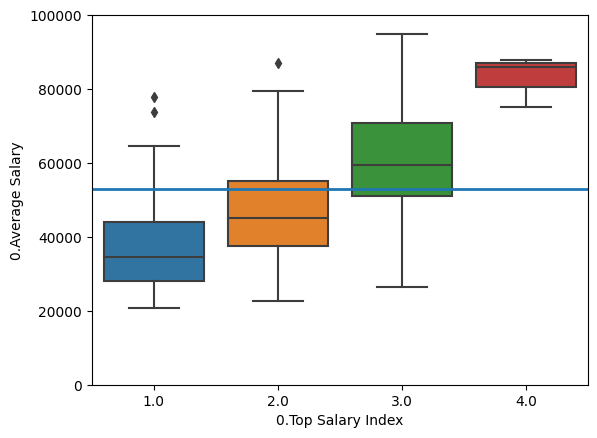

In [118]:
sns.boxplot(data=similarity, x='0.Top Salary Index', y='0.Average Salary')
plt.axline((0, 53000), slope=0, linewidth=2)
plt.ylim(0,100000)

(0.0, 1500000.0)

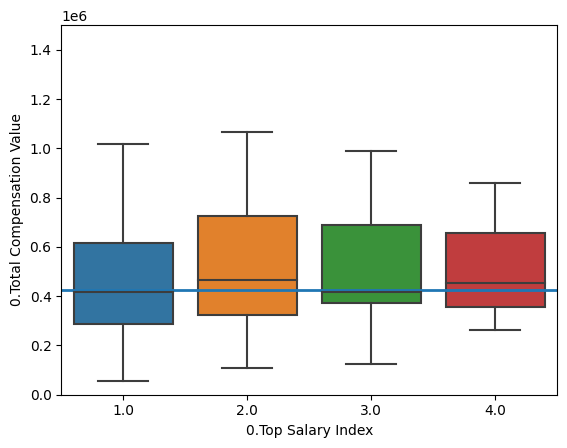

In [119]:
sns.boxplot(data=similarity, x='0.Top Salary Index', y='0.Total Compensation Value')
plt.axline((0, 423000), slope=0, linewidth=2)
plt.ylim(0,1.5e6)

(0.0, 1.0)

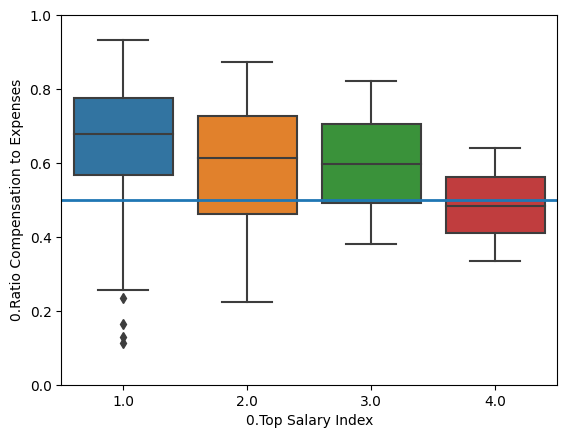

In [120]:
sns.boxplot(data=similarity, x='0.Top Salary Index', y='0.Ratio Compensation to Expenses')
plt.axline((0, 0.5), slope=0, linewidth=2)
plt.ylim(0,1)

In [121]:
df["0.Top Salary Index"][(df["0.Full Time Employees"].between(4, 8)) & (df['0.Part Time Employees'].between(0, 4))].mean()

1.5227272727272727

(0.0, 10000000.0)

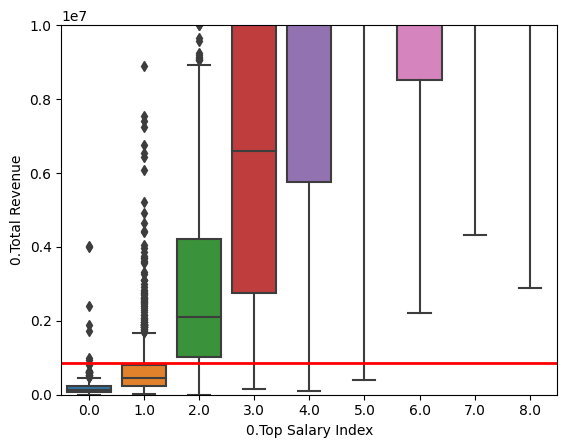

In [122]:
sns.boxplot(data=df, x='0.Top Salary Index', y='0.Total Revenue')
plt.axline((0, 860000), slope=0, linewidth=2, color="red")
plt.ylim(0, 1e7)

(0.0, 1.0)

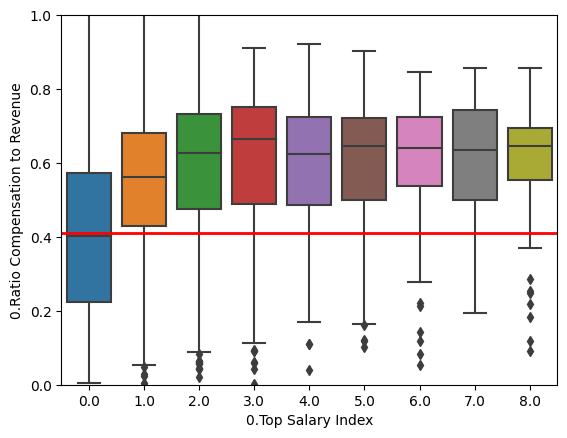

In [192]:
sns.boxplot(data=df, x='0.Top Salary Index', y='0.Ratio Compensation to Revenue')
plt.axline((0, 0.41), slope=0, linewidth=2, color="red")
plt.ylim(0, 1)

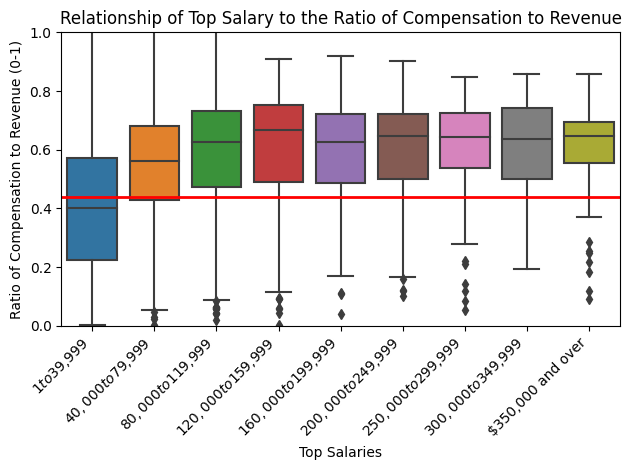

In [261]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Ratio Compensation to Revenue')
plt.axline((0, 0.44), slope=0, linewidth=2, color="red")
plt.ylim(0, 1)
plt.title("Relationship of Top Salary to the Ratio of Compensation to Revenue")
plt.ylabel("Ratio of Compensation to Revenue (0-1)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

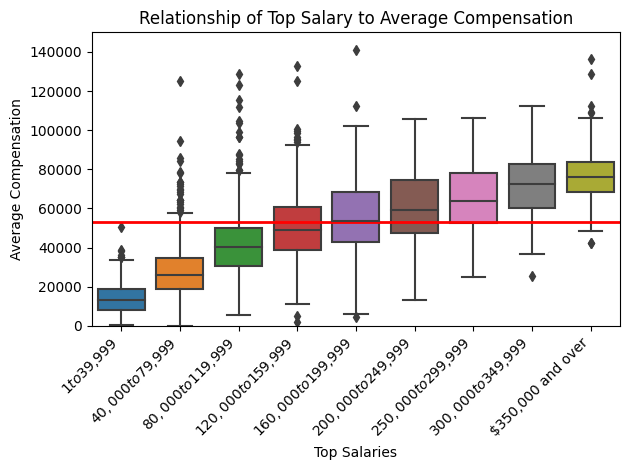

In [257]:
chart =sns.boxplot(data=df, x='0.Top Salary Index', y='0.Average Salary')
plt.axline((0, 53000), slope=0, linewidth=2, color="red")
plt.ylim(0, 150000)
plt.title("Relationship of Top Salary to Average Compensation")
plt.ylabel("Average Compensation")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='0.Top Salary Index', ylabel='0.Average Salary'>

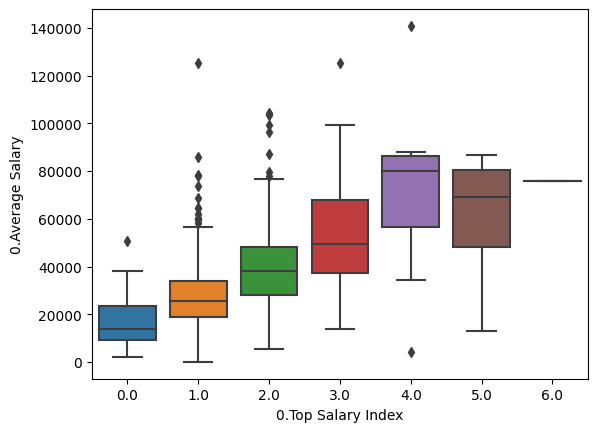

In [124]:
sns.boxplot(data=df[df["0.Total Revenue"].between(2.5e5, 2.5e6)], x='0.Top Salary Index', y='0.Average Salary')
# plt.axline((3, 0), slope=np.inf, linewidth=2, color="red")
# plt.axline((3.05, 0), slope=np.inf, linewidth=2, color="lightgreen")
#plt.ylim(2,10)

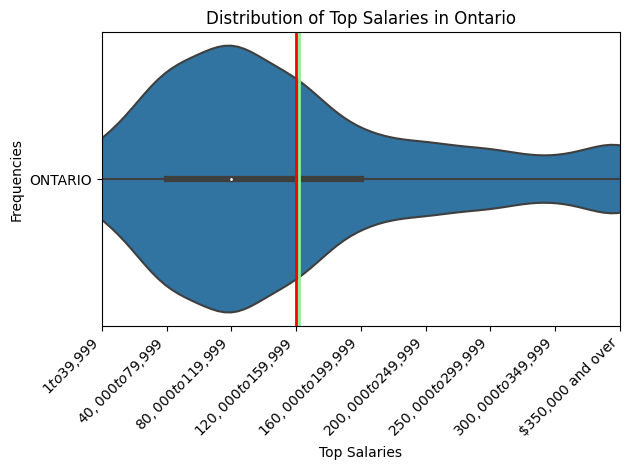

In [244]:
chart = sns.violinplot(data=df[df.province == "ONTARIO"], x='0.Top Salary Index', y='province')
plt.axline((3, 0), slope=np.inf, linewidth=2, color="red")
plt.axline((3.05, 0), slope=np.inf, linewidth=2, color="lightgreen")
plt.xlim(0,8)
plt.title("Distribution of Top Salaries in Ontario")
plt.ylabel("Frequencies")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [126]:
df["0.Top Salary Index"][df.city == "ONTARIO"].mean()

3.0472659870250234

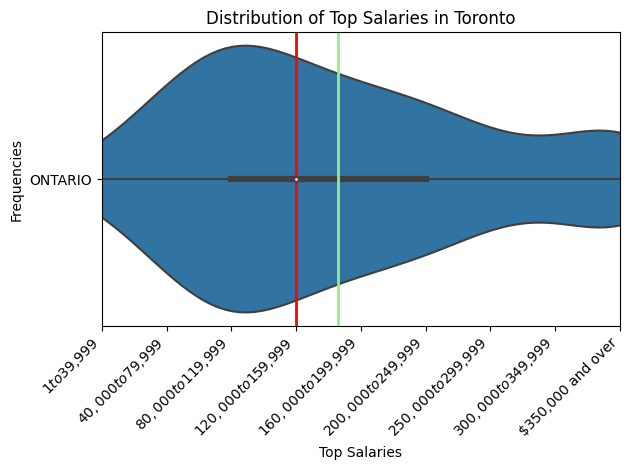

In [246]:
chart =sns.violinplot(data=df[df.city == "TORONTO"], x='0.Top Salary Index', y='province')
plt.axline((3, 0), slope=np.inf, linewidth=2, color="red")
plt.axline((3.64, 0), slope=np.inf, linewidth=2, color="lightgreen")
plt.xlim(0,8)
plt.title("Distribution of Top Salaries in Toronto")
plt.ylabel("Frequencies")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [128]:
similarity[similarity["0.Top Salary Index"] == 5]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Compensation to Revenue,0.Ratio Compensation to Expenses,0.Ratio Part Time to Full Time,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index


## Average Tot Revenue of Charities by Top Salary Index

In [174]:
df["0.Total Revenue"][df["0.Top Salary Index"] == 1].quantile(0.25)

248122.0

In [159]:
bins = range(9)
medians = []
lower_quart = []
upper_quart = []
for i in range(9):
    tot_revs = df["0.Total Revenue"][df["0.Top Salary Index"] == i]
    medians.append(tot_revs.median())
    lower_quart.append(tot_revs.quantile(0.25))
    

138338.0
440290.0
2103923.0
6599736.0
11838530.5
21495657.5
36034759.5
28800062.5
291291741.5


In [160]:
salary_bin_to_avg_total_revenue

{0: 138338.0,
 1: 440290.0,
 2: 2103923.0,
 3: 6599736.0,
 4: 11838530.5,
 5: 21495657.5,
 6: 36034759.5,
 7: 28800062.5,
 8: 291291741.5}

In [163]:
df["0.Total Revenue"][df["0.Top Salary Index"] == 7].describe()

count    5.000000e+01
mean     3.479026e+08
std      6.630332e+08
min      4.317212e+06
25%      1.222675e+07
50%      2.880006e+07
75%      1.771636e+08
max      2.487983e+09
Name: 0.Total Revenue, dtype: float64

## Province Average Top Salary Index

In [129]:
for province in df.province.unique():
    avg_top_salary = df["0.Top Salary Index"][df.province == province].mean()
    print(province, avg_top_salary)

QUEBEC 1.369713506139154
ALBERTA 2.111111111111111
NEW BRUNSWICK 1.25
ONTARIO 3.0472659870250234
BRITISH COLUMBIA 1.9733009708737863
NOVA SCOTIA 1.5588235294117647
SASKATCHEWAN 1.9591836734693877
MANITOBA 1.9435483870967742
PEI 0.9090909090909091
NEWFOUNDLAND AND LABRADOR 1.837837837837838
NORTHWEST TERRITORIES 3.2
YUKON 1.8571428571428572


In [130]:
city_avg_top_salary = {}
for city in df.city.unique():
    avg_top_salary = df["0.Top Salary Index"][df.city == city].mean()
    if not np.isnan(avg_top_salary):
        city_avg_top_salary[city] = avg_top_salary

In [131]:
Counter(city_avg_top_salary)

Counter({'SHERBROOKE': 1.1666666666666667,
         'ST. PAUL': 2.0,
         'MIRABEL': 2.0,
         'LONGUEUIL': 1.8125,
         'CAP-SANTE': 0.0,
         'MONTREAL': 1.9383561643835616,
         'SHEDIAC': 1.3333333333333333,
         'MONTRÉAL': 1.2142857142857142,
         'MEMRAMCOOK': 1.0,
         'BURLINGTON': 2.8181818181818183,
         'THORNHILL': 1.5,
         'MISSISSAUGA': 2.923076923076923,
         'ST-JEAN-SUR-RICHELIEU': 2.0,
         'VICTORIA': 2.4444444444444446,
         'FORT MCMURRAY': 1.4,
         'JOLIETTE': 1.4166666666666667,
         'TORONTO': 3.640449438202247,
         'QUAQTAQ': 2.0,
         'NORTH YORK': 3.125,
         'SIDNEY': 1.5,
         'NORTH BAY': 3.1818181818181817,
         'LAKEFIELD': 1.0,
         'ALLISTON': 3.3333333333333335,
         'KINGSTON': 3.0833333333333335,
         'VERDUN': 0.75,
         'QUEBEC': 1.7837837837837838,
         'SAINT-JEAN-SUR-RICHELIEU': 1.5,
         'OTTAWA': 3.3488372093023258,
         'CHANDLER':

## Why small top salaries

(0.0, 10000000.0)

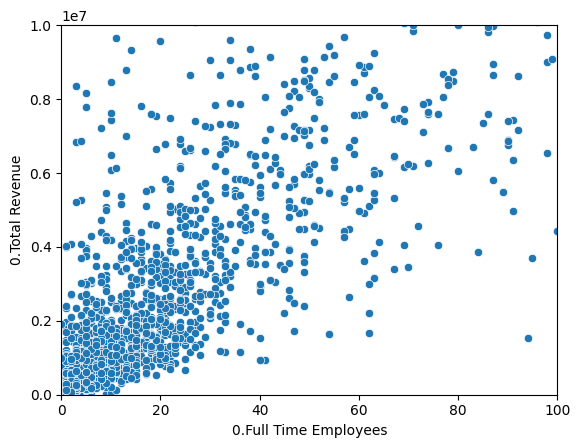

In [132]:
sns.scatterplot(data=df, x="0.Full Time Employees", y="0.Total Revenue")
plt.xlim(0, 100)
plt.ylim(0, 1e7)

In [133]:
zero = df[df["0.Top Salary Index"] == 0]
one = df[df["0.Top Salary Index"] == 1]
two = df[df["0.Top Salary Index"] == 2]
three = df[df["0.Top Salary Index"] == 3]
four = df[df["0.Top Salary Index"] == 4]

In [ ]:
# Small Top Salaries tend to have significantly more Part Time to Full Time Employees
sns.boxplot(data=df, x='0.Top Salary Index', y='0.Ratio Part Time to All Employees')
plt.ylim(0,1)

In [ ]:
one[one["0.Part Time Employees"] > 1000]

In [ ]:
# PT > FT Employees, Tot Revenue >> Tot Expenses
zero[zero["0.Total Revenue"] == zero["0.Total Revenue"].max()]

## END

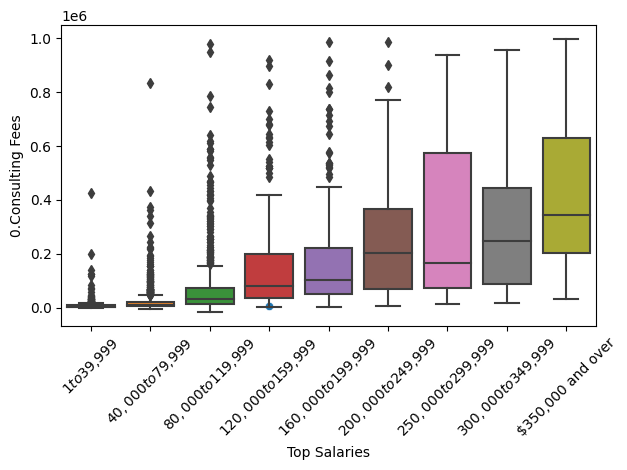

In [142]:
chart = sns.boxplot(data=df[df["0.Consulting Fees"]<1e6], x='0.Top Salary Index', y='0.Consulting Fees')
draw_lcc(chart)
# plt.title("Relationship of Top Salaries to Total Revenue")
# plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45)
plt.tight_layout()
plt.show()

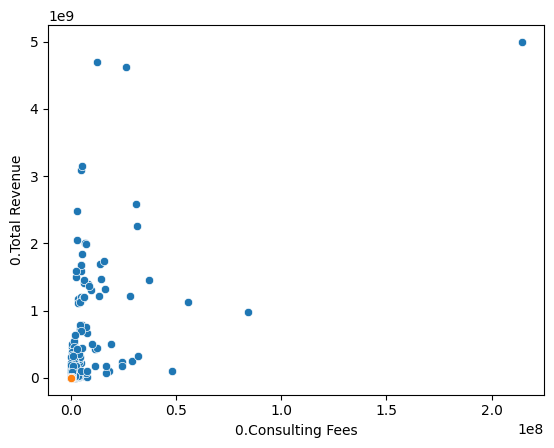

In [246]:
chart = sns.scatterplot(data=df, x='0.Consulting Fees', y='0.Total Revenue')
draw_lcc(chart)
# plt.title("Relationship of Top Salaries to Total Revenue")
# plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
# plt.xlabel("Top Salaries")
# chart.set_xticks(range(9))
# chart.set_xticklabels(salary_bin_labels, rotation=45)
# plt.tight_layout()
plt.show()

In [247]:
df[df["0.Consulting Fees"] > 2e8]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses,0.Ratio Part Time to All Employees
4821,22871,895830180RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 32929...,"{'$350,000 and over': '10'}",Ongoing programs: \n\t\n\tThe Saskatchewan Hea...,"{'Receipted donations': 1217503.0, 'Non-receip...","{'Charitable programs': 4497848233.0, 'Managem...",{'Total compensation for all positions': 31721...,"{'$350,000 and over': '10'}",...,Health Care,40160.0,81994.647634,65.923972,0.65924,4.669499e+09,0.934834,8.0,0.664356,0.932721


In [55]:
df.head()

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,province,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index
0,0,858665102RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 27397...,"{'$1 to $39,999': '5', '$40,000 to $79,999': '1'}",Ongoing programs: \n\t\n\tOFFRIR DES SERVICES ...,"{'Receipted donations': 1615.0, 'Non-receipted...","{'Charitable programs': 264111.0, 'Management ...",{'Total compensation for all positions': 25070...,"{'$1 to $39,999': '4', '$40,000 to $79,999': '1'}",...,QUEBEC,6349540f044a88e546303ade,Health Care,11.0,24906.454545,75.798178,0.757982,350865.0,0.970721,1.0
1,5,108035544RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 76152...,"{'$40,000 to $79,999': '3', '$80,000 to $119,9...",Ongoing programs: \n\t\n\t1. Mental Health Pro...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 8195848.0, 'Management...",{'Total compensation for all positions': 71300...,"{'$40,000 to $79,999': '6', '$80,000 to $119,9...",...,ALBERTA,6349540f044a88e546303ae3,Health Care,191.0,39870.204188,76.726356,0.767264,8218631.0,0.828061,3.0
2,10,803557529RR0001,2022-03-31\n2021-03-31,{'Total compensation for all positions': 19032...,"{'$1 to $39,999': '2', '$40,000 to $79,999': '5'}",Ongoing programs: \n\t\n\tNous offrons un serv...,"{'Receipted donations': 3618.0, 'Non-receipted...","{'Charitable programs': 172987.0, 'Management ...",{'Total compensation for all positions': 13411...,"{'$1 to $39,999': '4', '$40,000 to $79,999': '1'}",...,QUEBEC,63495415044a88e546303b04,Health Care,9.0,21146.666667,53.030767,0.530308,206206.0,0.574572,1.0
3,12,896147386RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 38067...,{},Ongoing programs: \n\t\n\tPROGRAMMES D'ÉDUCATI...,"{'Receipted donations': 1000.0, 'Non-receipted...","{'Charitable programs': 0.0, 'Management and a...",{'Total compensation for all positions': 45458...,"{'$40,000 to $79,999': '6'}",...,QUEBEC,634955656f4326e0a00a60b9,Health Care,NaN,NaN,64.953384,0.649534,584725.0,0.997708,NaN
4,17,739774727RR0001,2021-05-31\n2020-05-31\n2019-05-31\n2018-05-31,{'Total compensation for all positions': 12914...,"{'$1 to $39,999': '2'}",Ongoing programs: \n\t\n\tÉquitation thérapeut...,"{'Receipted donations': 3404.0, 'Non-receipted...","{'Charitable programs': 3028.0, 'Management an...","{'Total compensation for all positions': nan, ...",{},...,QUEBEC,634955656f4326e0a00a60bf,Health Care,4.0,3228.500000,35.537577,0.355376,2369.0,0.065192,0.0


In [56]:
# Number of Charities from each Province/Territory
df.province.value_counts()

ONTARIO                      2144
QUEBEC                       1266
BRITISH COLUMBIA             1000
ALBERTA                       603
NOVA SCOTIA                   283
SASKATCHEWAN                  278
MANITOBA                      276
NEW BRUNSWICK                 164
NEWFOUNDLAND AND LABRADOR      77
PEI                            36
YUKON                          12
NORTHWEST TERRITORIES           9
Name: province, dtype: int64

In [57]:
# Number of Charities from top 10 cities
df.city.value_counts()[:10]

TORONTO      360
MONTREAL     255
VANCOUVER    188
CALGARY      186
OTTAWA       149
WINNIPEG     144
EDMONTON     126
VICTORIA      81
SASKATOON     65
LONDON        63
Name: city, dtype: int64

### Removing the Main Outlier: Alberta Health Services

In [17]:
# Removing Alberta Health Services
df = df[df["BN/Registration number"] != "124072513RR0010"]

In [18]:
df.to_csv("the_health_care_charity_data.csv")

### Helper Function for Highlighting Lung Cancer Canada

In [139]:
lcc = df[df.name == "LUNG CANCER CANADA CANCER PULMONAIRE CANADA"]

def draw_lcc(main_chart, kind='scatter'):
    x_label = main_chart.get_xlabel()
    y_label = main_chart.get_ylabel()
    if kind == "scatter":
        sns.scatterplot(data=lcc, x=x_label, y=y_label)

In [140]:
lcc

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Compensation to Revenue,0.Ratio Compensation to Expenses,0.Ratio Part Time to Full Time,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index
3403,16239,872775119RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31...,{'Total compensation for all positions': 42266...,"{'$1 to $39,999': '2', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tTO RAISE AWARENESS A...,"{'Receipted donations': 152898.0, 'Non-receipt...","{'Charitable programs': 568940.0, 'Management ...",{'Total compensation for all positions': 37838...,"{'$1 to $39,999': '1', '$40,000 to $79,999': '...",...,Health Care,8.0,52833.0,49.051384,0.490514,0.650322,0.333333,0.0,0.0,3.0


In [141]:
lcc["0.SalaryArray"]

3403    [2, 2, 1, 1, 0, 0, 0, 0, 0]
Name: 0.SalaryArray, dtype: object

In [213]:
df[df["0.SalaryArray"] == "[2, 2, 1, 1, 0, 0, 0, 0, 0]"]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses
3403,16239,872775119RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31...,{'Total compensation for all positions': 42266...,"{'$1 to $39,999': '2', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tTO RAISE AWARENESS A...,"{'Receipted donations': 152898.0, 'Non-receipt...","{'Charitable programs': 568940.0, 'Management ...",{'Total compensation for all positions': 37838...,"{'$1 to $39,999': '1', '$40,000 to $79,999': '...",...,63497675bbe078d684f22a04,Health Care,8.0,52833.0,49.051384,0.490514,0.0,0.0,3.0,0.650322


In [220]:
dict(df["0.Full Time Employees"].value_counts())

{1.0: 409,
 2.0: 251,
 3.0: 189,
 5.0: 135,
 4.0: 117,
 6.0: 100,
 0.0: 84,
 7.0: 67,
 8.0: 66,
 10.0: 63,
 9.0: 54,
 11.0: 48,
 18.0: 40,
 12.0: 40,
 13.0: 39,
 15.0: 38,
 14.0: 34,
 21.0: 32,
 17.0: 30,
 22.0: 28,
 24.0: 27,
 16.0: 26,
 19.0: 26,
 25.0: 24,
 20.0: 23,
 26.0: 20,
 27.0: 18,
 23.0: 18,
 33.0: 18,
 49.0: 16,
 31.0: 14,
 29.0: 14,
 46.0: 14,
 32.0: 13,
 28.0: 13,
 30.0: 12,
 38.0: 12,
 35.0: 12,
 47.0: 11,
 41.0: 11,
 50.0: 11,
 51.0: 10,
 34.0: 10,
 39.0: 10,
 69.0: 9,
 78.0: 9,
 60.0: 9,
 37.0: 9,
 36.0: 9,
 40.0: 9,
 43.0: 8,
 67.0: 8,
 96.0: 8,
 79.0: 8,
 63.0: 8,
 109.0: 8,
 87.0: 8,
 54.0: 7,
 52.0: 7,
 75.0: 7,
 62.0: 7,
 74.0: 7,
 61.0: 6,
 58.0: 6,
 45.0: 6,
 83.0: 6,
 105.0: 6,
 42.0: 6,
 70.0: 6,
 90.0: 6,
 94.0: 5,
 73.0: 5,
 100.0: 5,
 80.0: 5,
 92.0: 5,
 124.0: 5,
 59.0: 5,
 48.0: 5,
 53.0: 5,
 145.0: 5,
 65.0: 5,
 57.0: 5,
 91.0: 5,
 55.0: 5,
 135.0: 5,
 142.0: 4,
 141.0: 4,
 106.0: 4,
 98.0: 4,
 149.0: 4,
 137.0: 4,
 153.0: 4,
 71.0: 4,
 119.0: 3,
 189.0:

In [228]:
df[(df["0.Full Time Employees"].isna()) & (df["1.Full Time Employees"].notnull())]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses
3,12,896147386RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 38067...,{},Ongoing programs: \n\t\n\tPROGRAMMES D'ÉDUCATI...,"{'Receipted donations': 1000.0, 'Non-receipted...","{'Charitable programs': 0.0, 'Management and a...",{'Total compensation for all positions': 45458...,"{'$40,000 to $79,999': '6'}",...,634955656f4326e0a00a60b9,Health Care,NaN,NaN,64.953384,0.649534,584725.0,0.997708,NaN,0.742094
69,295,744936287RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31,{'Total compensation for all positions': 16250...,{},Ongoing programs: \n\t\n\tFORMATION EN SOINS P...,"{'Receipted donations': 9275.0, 'Non-receipted...","{'Charitable programs': 51208.0, 'Management a...",{'Total compensation for all positions': 4461....,"{'$1 to $39,999': '1'}",...,634955f76f4326e0a00a6395,Health Care,NaN,NaN,14.701359,0.147014,89838.0,0.812763,NaN,0.215049
111,479,815505110RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,"{'Total compensation for all positions': nan, ...",{},Ongoing programs:,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 0.0, 'Management and a...",{'Total compensation for all positions': 26577...,{},...,6349564e6f4326e0a00a6555,Health Care,NaN,NaN,NaN,NaN,34335.0,0.618704,NaN,NaN
112,484,813245636RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,"{'Total compensation for all positions': nan, ...",{},Ongoing programs: \n\t\n\tADULT DAY PROGRAMS,"{'Receipted donations': 21798.0, 'Non-receipte...","{'Charitable programs': 21798.0, 'Management a...",{'Total compensation for all positions': 2073....,{},...,634956536f4326e0a00a6562,Health Care,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
144,621,100356476RR0001,2020-03-31\n2019-03-31\n2018-03-31\n2017-03-31...,"{'Total compensation for all positions': nan, ...",{},Ongoing programs: \n\t\n\tACTIVITÉS ET DONS PO...,"{'Receipted donations': 736.0, 'Non-receipted ...","{'Charitable programs': 86569.0, 'Management a...",{'Total compensation for all positions': 35301...,"{'$1 to $39,999': '1'}",...,634956996f4326e0a00a66e1,Health Care,NaN,NaN,NaN,NaN,16050.0,0.079536,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5960,28317,870382751RR0001,2020-12-31\n2019-12-31\n2018-12-31\n2017-12-31...,"{'Total compensation for all positions': nan, ...",{},Ongoing programs: \n\t\n\tTHE FUNDS DONATED PL...,"{'Receipted donations': 62756.0, 'Non-receipte...","{'Charitable programs': 132503.0, 'Management ...",{'Total compensation for all positions': 20000...,"{'$1 to $39,999': '1'}",...,634993915e359e534e43fa01,Health Care,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN
5961,28322,899928725RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 81249...,{},Ongoing programs: \n\t\n\tSERVING THE ABORIGIN...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 0.0, 'Management and a...",{'Total compensation for all positions': 69467...,"{'$80,000 to $119,999': '8', '$120,000 to $159...",...,634993915e359e534e43fa04,Health Care,NaN,NaN,67.820817,0.678208,10288861.0,0.858830,NaN,0.679503
6054,28779,119300473RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,"{'Professional and consulting fees': nan, 'Tot...",{},Ongoing programs: \n\t\n\tSupport services for...,"{'Receipted donations': nan, 'Non-receipted do...","{'Charitable programs': nan, 'Management and a...",{'Total compensation for all positions': 32231...,"{'$1 to $39,999': '2', '$40,000 to $79,999': '...",...,6349948d5e359e534e43fee7,Health Care,NaN,NaN,NaN,NaN

In [215]:
df[(df["0.SalaryArray"] == "[0, 0, 0, 0, 0, 0, 0, 0, 0]") & (df["0.Salary"] != "{}")]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses
1172,5489,863673984RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31...,{'Total compensation for all positions': 6892....,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tCommunity outreach\n...,"{'Receipted donations': 19411.0, 'Non-receipte...","{'Charitable programs': 6163.0, 'Management an...",{'Total compensation for all positions': 4979....,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",...,63495d8e6f4326e0a00a8db7,Health Care,2.0,3446.000000,25.908800,0.259088,7190.0,0.270291,NaN,0.527920
1810,8630,803344720RR0002,2021-12-31\n2020-12-31,{'Total compensation for all positions': 9787....,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tThe Dwarf Athletic A...,"{'Receipted donations': 10613.0, 'Non-receipte...","{'Charitable programs': 9807.0, 'Management an...",{'Total compensation for all positions': 5126....,{},...,6349640acd1ff4e263ac6fbd,Health Care,3.0,3262.333333,48.561080,0.485611,9541.0,0.473405,NaN,0.974704
1910,9119,118890821RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31...,{'Total compensation for all positions': 28845...,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tOperations of a trai...,"{'Receipted donations': 10000.0, 'Non-receipte...","{'Charitable programs': 109180.0, 'Management ...",{'Total compensation for all positions': 44429...,{},...,634964d8cd1ff4e263ac742c,Health Care,10.0,2884.500000,9.678166,0.096782,10000.0,0.033552,NaN,0.131918
2363,11254,895460525RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31...,{'Total compensation for all positions': 3523....,"{'$1 to $39,999': '0'}",Ongoing programs: \n\t\n\tFreedom Trails provi...,"{'Receipted donations': 7426.0, 'Non-receipted...","{'Charitable programs': 50199.0, 'Management a...","{'Full-time employees': nan, 'Part-time employ...",{},...,63496be2bbe078d684f1ec49,Health Care,1.0,3523.000000,6.781651,0.067817,8500.0,0.163622,NaN,0.060472
2804,13391,107504219RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 30372...,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tPROVIDE AMBULANCE SE...,"{'Receipted donations': 27500.0, 'Non-receipte...","{'Charitable programs': 358890.0, 'Management ...",{'Total compensation for all positions': 26773...,{},...,63496ff2bbe078d684f20454,Health Care,13.0,23363.384615,64.844254,0.648443,165538.0,0.353419,NaN,0.748511
4137,19669,703593327RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31,{'Total compensation for all positions': 63149...,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\t-providing support a...,"{'Receipted donations': 188141.0, 'Non-receipt...","{'Charitable programs': 74225.0, 'Management a...",{'Total compensation for all positions': 59471...,{},...,63497f075e359e534e4383ce,Health Care,3.0,21049.666667,28.136250,0.281363,0.0,0.000000,NaN,0.503577
5324,25257,871161741RR0001,2021-09-30\n2020-09-30\n2019-09-30\n2018-09-30...,{'Total compensation for all positions': 10053...,"{'$1 to $39,999': '0', '$40,000 to $79,999': '...",Ongoing programs: \n\t\n\tProvide education an...,"{'Receipted donations': 4702.0, 'Non-receipted...","{'Charitable programs': 131580.0, 'Management ...",{'Total compensation for all positions': 12941...,{},...,63498b935e359e534e43cd0f,Health Care,1.0,10053.000000,7.841103,0.078411,114498.0,0.893057,NaN,0.064875
5820,27668,842562704RR0001,2021-12-31\n2020-12-31\n2019-12-31\n2018-12-31...,{'Total compensation for all positions': 35760...,"{'$1 to $39,999': '0', '$40,000 to $79,9

In [209]:
df["0.SalaryArray"].value_counts()

[0, 0, 0, 0, 0, 0, 0, 0, 0]    3217
[0, 1, 0, 0, 0, 0, 0, 0, 0]     203
[1, 0, 0, 0, 0, 0, 0, 0, 0]     173
[0, 9, 1, 0, 0, 0, 0, 0, 0]     110
[1, 1, 0, 0, 0, 0, 0, 0, 0]      76
                               ... 
[0, 0, 3, 5, 0, 0, 0, 2, 0]       1
[2, 4, 2, 0, 0, 0, 0, 0, 0]       1
[1, 0, 1, 1, 0, 0, 0, 0, 0]       1
[0, 0, 0, 3, 4, 2, 0, 0, 1]       1
[0, 0, 0, 0, 0, 1, 1, 2, 2]       1
Name: 0.SalaryArray, Length: 727, dtype: int64

In [206]:
df["0.Top Salary Index"].value_counts(dropna=False)

NaN    3217
1.0     989
2.0     733
3.0     365
0.0     341
4.0     153
5.0     106
8.0     104
6.0      88
7.0      51
Name: 0.Top Salary Index, dtype: int64

## Exploration of Distributions

In the graphs below I am exploring the distributions of data point for various columns.
This helps me visualize where the majority of the data sits for different columns of data.

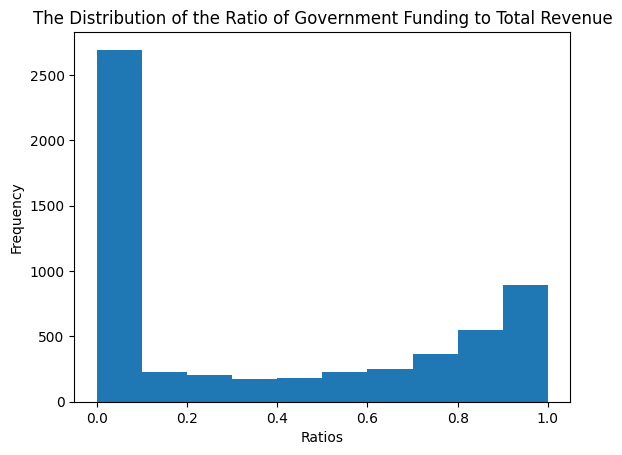

In [14]:
df["0.Ratio Government Funding to Total Revenue"].plot(kind="hist")
plt.title("The Distribution of the Ratio of Government Funding to Total Revenue")
plt.xlabel("Ratios")
plt.show()

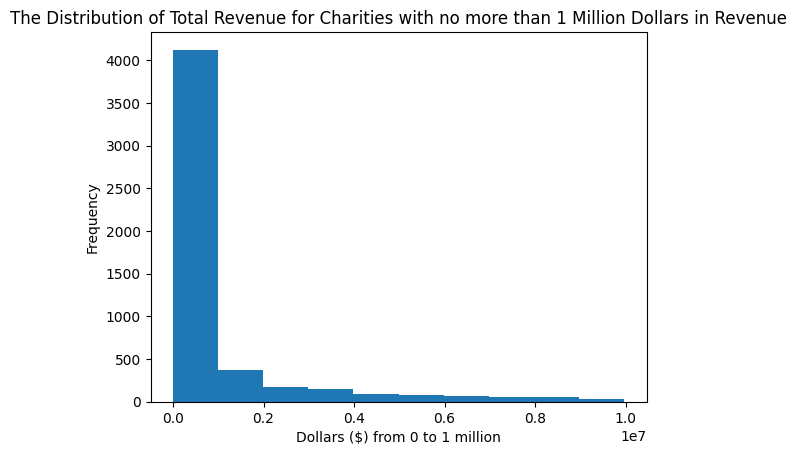

In [136]:
# Only the charities with a total revenue of a million dollars or less
df["0.Total Revenue"][df["0.Total Revenue"] <= 1e7].plot(kind="hist")
plt.title("The Distribution of Total Revenue for Charities with no more than 1 Million Dollars in Revenue")
plt.xlabel("Dollars ($) from 0 to 1 million")
plt.show()

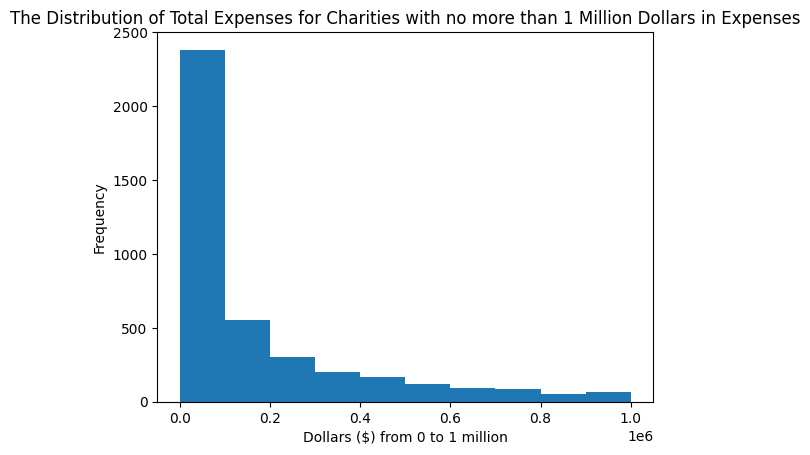

In [16]:
# Only the charities with a total expenses of a million dollars or less
df["0.Total Expenses"][df["0.Total Expenses"] <= 1e6].plot(kind="hist")
plt.title("The Distribution of Total Expenses for Charities with no more than 1 Million Dollars in Expenses")
plt.xlabel("Dollars ($) from 0 to 1 million")
plt.show()

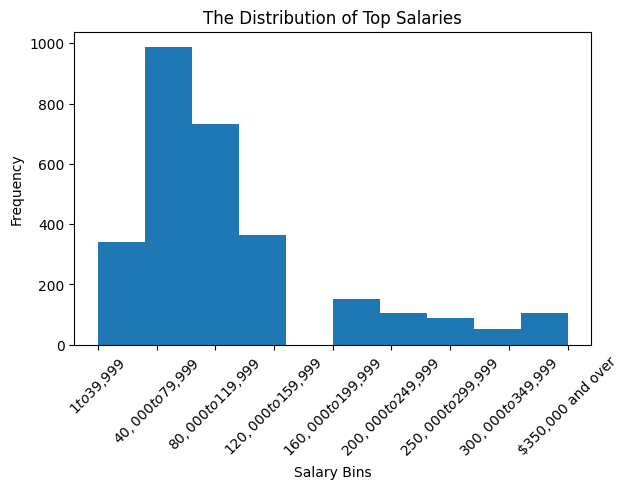

In [17]:
ax = df["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

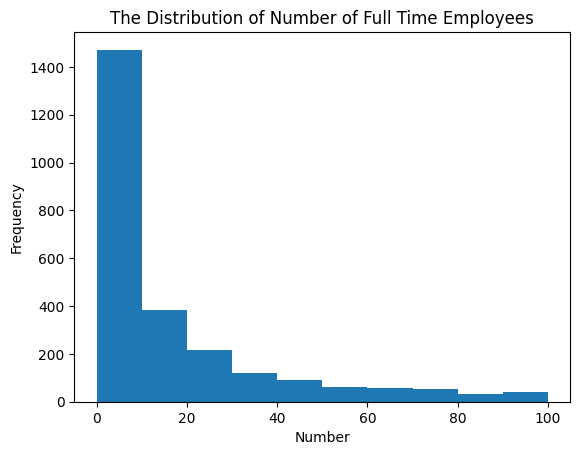

In [139]:
# For Charities with less than 100 full time employees, since a few charities have thousands to tens of thousands
df["0.Full Time Employees"][df["0.Full Time Employees"] <= 100].plot(kind="hist")
plt.title("The Distribution of Number of Full Time Employees")
plt.xlabel("Number")
plt.show()

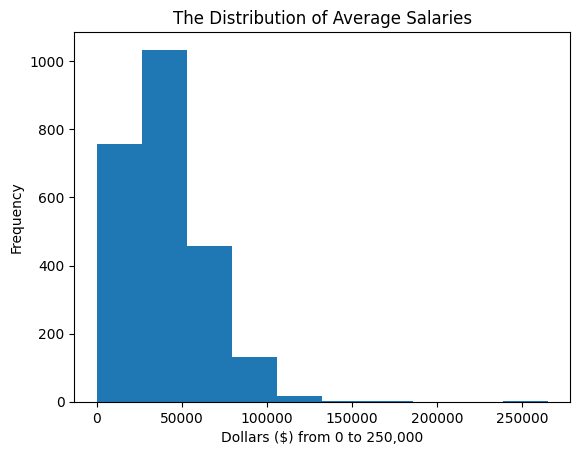

In [19]:
df["0.Average Salary"].plot(kind="hist")
plt.title("The Distribution of Average Salaries")
plt.xlabel("Dollars ($) from 0 to 250,000")
plt.show()

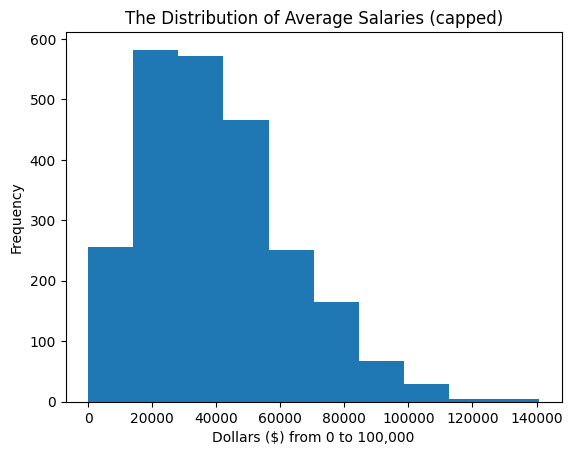

In [147]:
# PLotting only the charities with average salaries of less than 100000
df["0.Average Salary"][df["0.Average Salary"] < 150000].plot(kind="hist")
plt.title("The Distribution of Average Salaries (capped)")
plt.xlabel("Dollars ($) from 0 to 100,000")
plt.show()

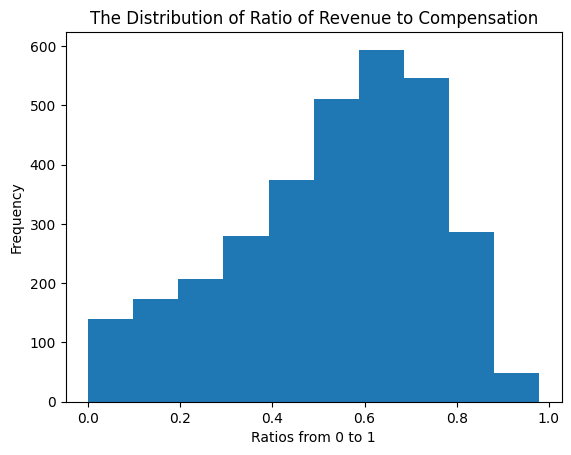

In [21]:
# Removing the charities that pay their employees more than their total revenue (46 charities)
df["0.Ratio Revenue to Compensation"][df["0.Ratio Revenue to Compensation"] <= 1].plot(kind="hist")
plt.title("The Distribution of Ratio of Revenue to Compensation")
plt.xlabel("Ratios from 0 to 1")
plt.show()

## Exploration of Top Salaries

The graphs below explore the relationship between the Top Salary Bin of each charity to other columns.
From these graphs you can compare how much effect certain variables have on the distribution of Top Salary Bins.

### By Frequencies

This graph adds up all the employees with a reported salary range (only the top 10 salary are required to be reported) for each Salary Bin and plots those in a Bar Plot

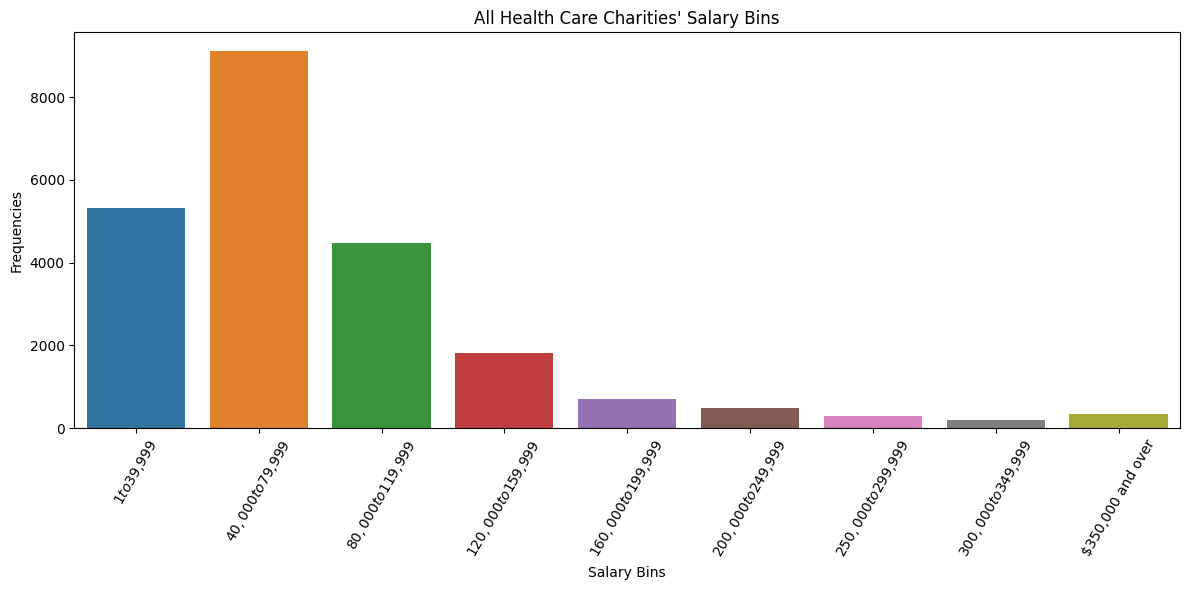

In [22]:
salary_list = salary_array_sum(df, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("All Health Care Charities' Salary Bins")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

### By Staff

#### The Orange Dots in the Scatterplots below represent Lung Cancer Canada

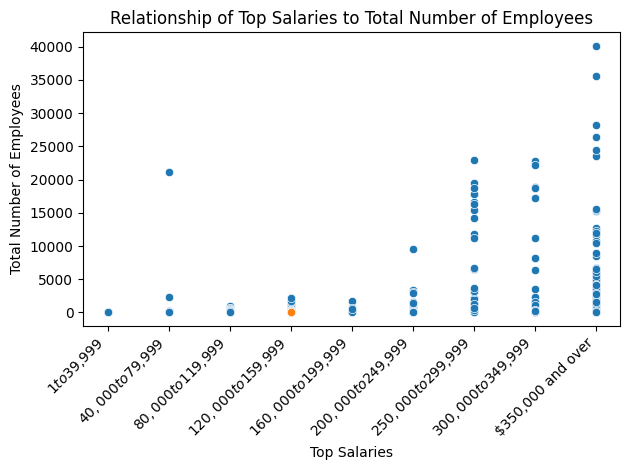

In [160]:
chart = sns.scatterplot(data=df, x='0.Top Salary Index', y='0.All Employees')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Number of Employees")
plt.ylabel("Total Number of Employees")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [148]:
df[(df["0.Top Salary Index"] == 1) & (df["0.All Employees"] > 20000)]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses
4435,21084,843450883RR0001,2021-04-30\n2020-04-30\n2019-04-30\n2018-04-30...,{'Total compensation for all positions': 32193...,"{'$1 to $39,999': '2', '$40,000 to $79,999': '2'}",Ongoing programs: \n\t\n\tRocky Mountain Adapt...,"{'Receipted donations': 188173.0, 'Non-receipt...","{'Charitable programs': 346144.0, 'Management ...",{'Total compensation for all positions': 27732...,"{'$40,000 to $79,999': '2'}",...,634981b25e359e534e439351,Health Care,21143.0,15.226647,48.58759,0.485876,133715.0,0.201806,1.0,0.626822


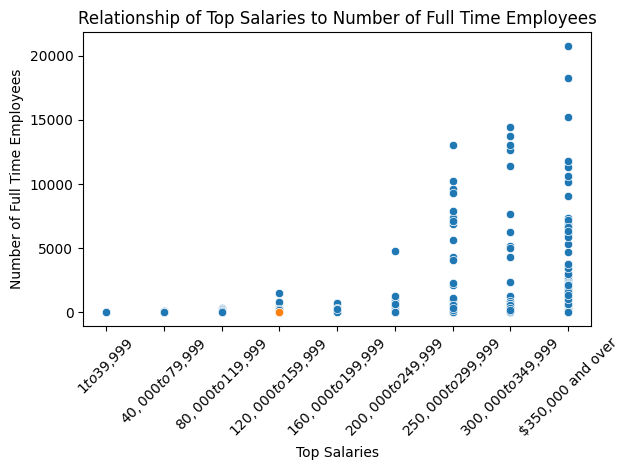

In [24]:
chart = sns.scatterplot(data=df, x='0.Top Salary Index', y='0.Full Time Employees')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Number of Full Time Employees")
plt.ylabel("Number of Full Time Employees")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45)
plt.tight_layout()
plt.show()

### By Expenses and Revenue

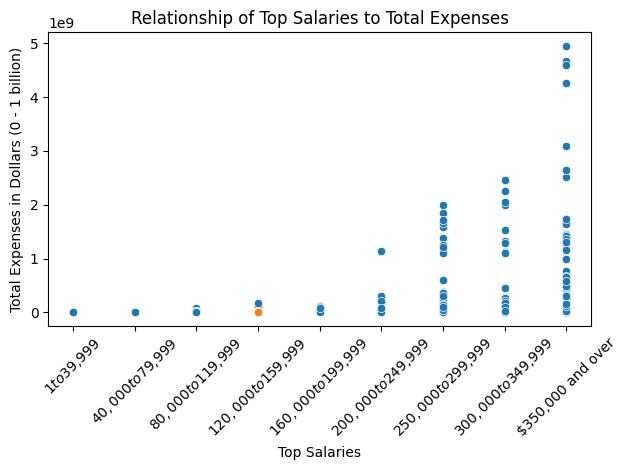

In [25]:
chart = sns.scatterplot(data=df, x='0.Top Salary Index', y='0.Total Expenses')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Expenses")
plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45)
plt.tight_layout()
plt.show()

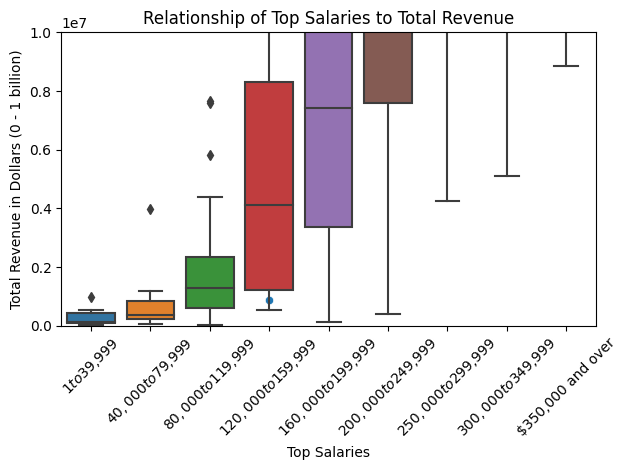

In [181]:
chart = sns.boxplot(data=df[df.city == "TORONTO"], x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Revenue in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
plt.ylim(0, 1e7)
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45)
plt.tight_layout()
plt.show()

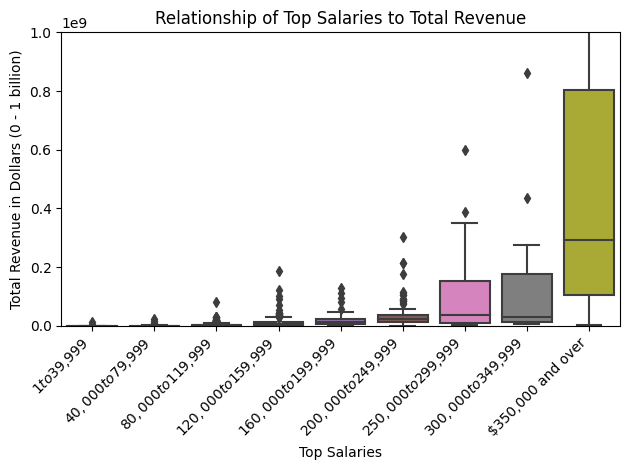

In [230]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Revenue in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
plt.ylim(0, 1e9)
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

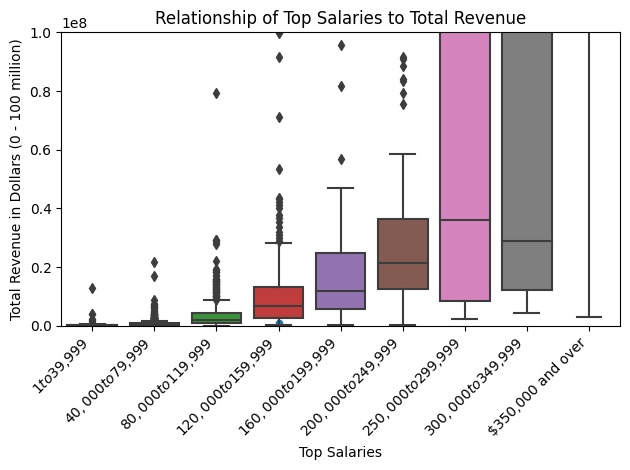

In [231]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Revenue in Dollars (0 - 100 million)")
plt.xlabel("Top Salaries")
plt.ylim(0, 1e8)
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

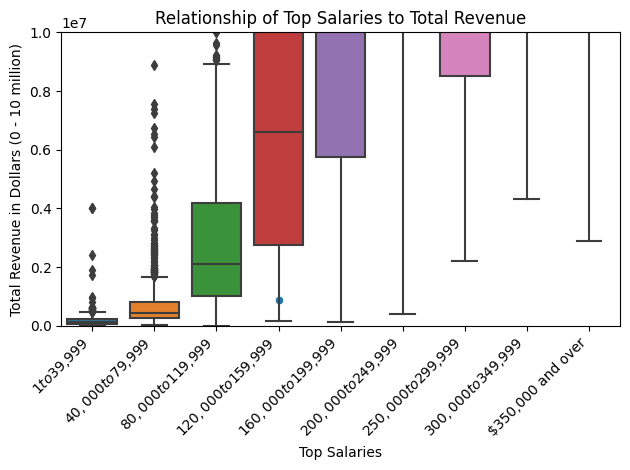

In [232]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Revenue in Dollars (0 - 10 million)")
plt.xlabel("Top Salaries")
plt.ylim(0, 1e7)
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

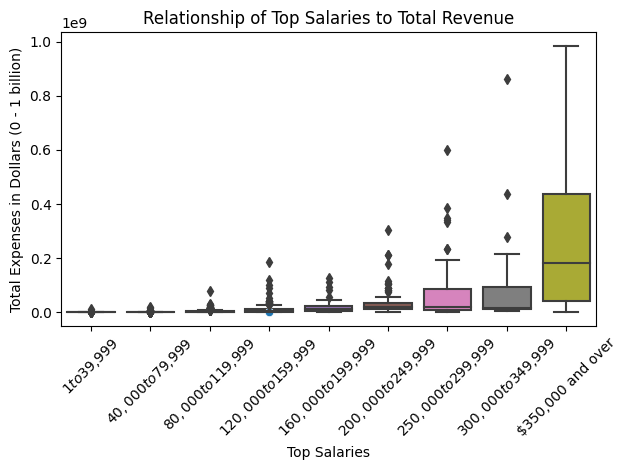

In [123]:
chart = sns.boxplot(data=df[df["0.Total Revenue"] <= 1e9], x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45)
plt.tight_layout()
plt.show()

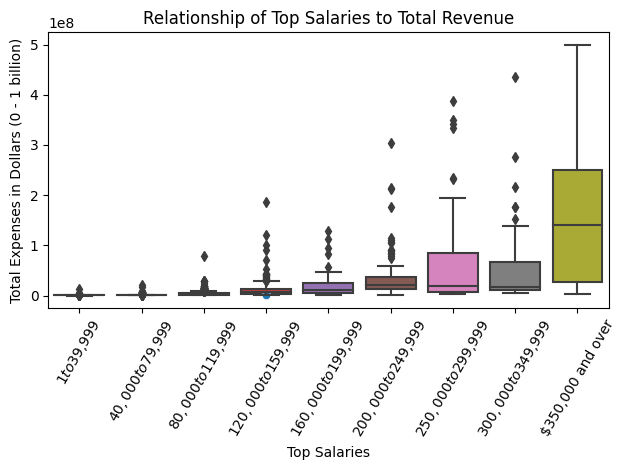

In [125]:
chart = sns.boxplot(data=df[df["0.Total Revenue"] <= 5e8], x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=60)
plt.tight_layout()
plt.show()

NameError: name 'draw_lcc' is not defined

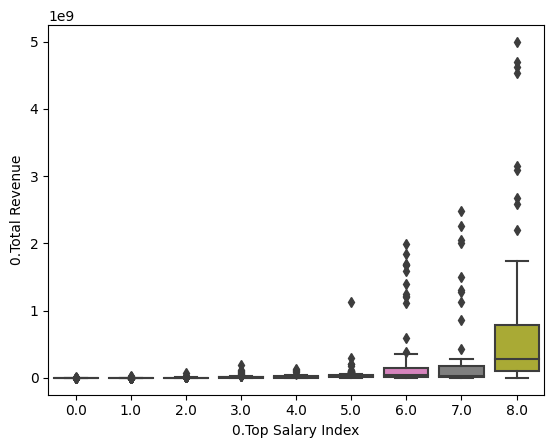

In [99]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Revenue in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=60)
plt.tight_layout()
plt.show()

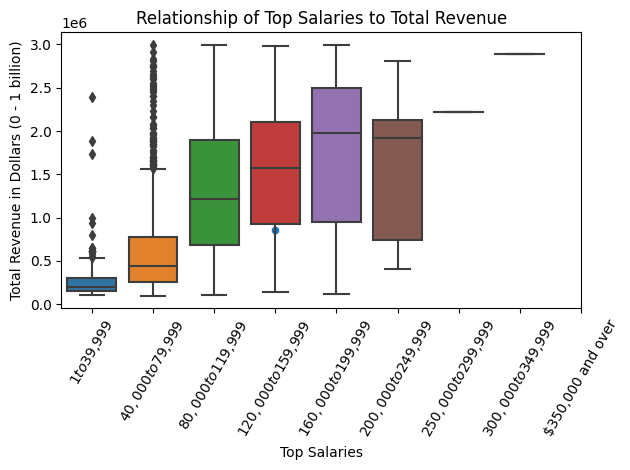

In [204]:
chart = sns.boxplot(data=df[df["0.Total Revenue"].between(1e5, 3e6)], x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Revenue in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=60)
plt.tight_layout()
plt.show()

In [156]:
df[(df["0.Top Salary Index"] == 5) & (df["0.Total Revenue"] < 5e5)]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses
2437,11602,803250588RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 34593...,"{'$80,000 to $119,999': '1', '$200,000 to $249...",Ongoing programs: \n\t\n\tNOUS BÂTISSONS UN RÉ...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 438468.0, 'Management ...",{'Total compensation for all positions': 35833...,"{'$120,000 to $159,999': '1', '$200,000 to $24...",...,63496cb3bbe078d684f1f12a,Health Care,NaN,NaN,82.088178,0.820882,0.0,0.000000,5.0,0.689584
2794,13344,897016275RR0001,2021-04-30\n2020-04-30\n2019-04-30\n2018-04-30...,{'Total compensation for all positions': 65077...,"{'$80,000 to $119,999': '1', '$120,000 to $159...",Ongoing programs: \n\t\n\tHypertension Canada ...,"{'Receipted donations': 2195.0, 'Non-receipted...","{'Charitable programs': 80875.0, 'Management a...",{'Total compensation for all positions': 88876...,"{'$80,000 to $119,999': '1', '$120,000 to $159...",...,63496fd5bbe078d684f20392,Health Care,5.0,13015.4,16.052857,0.160529,1520.0,0.003749,5.0,0.145807


### By Government Funding

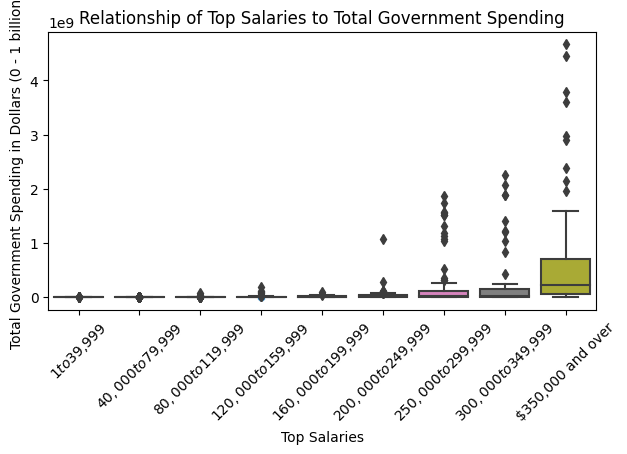

In [27]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Government Funding')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Government Spending")
plt.ylabel("Total Government Spending in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45)
plt.tight_layout()
plt.show()

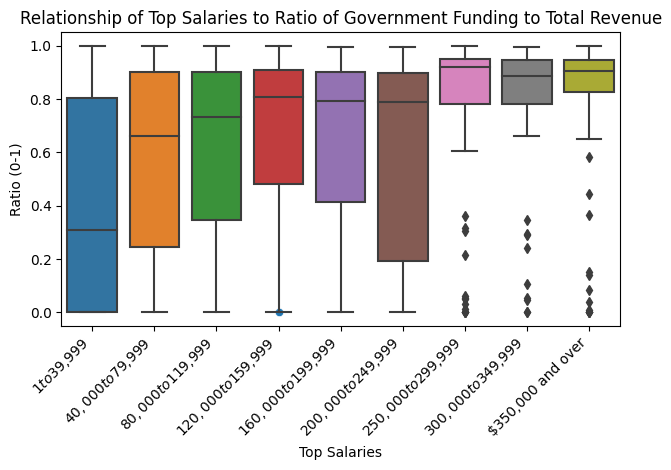

In [233]:
chart = sns.boxplot(data=df, x='0.Top Salary Index', y='0.Ratio Government Funding to Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Ratio of Government Funding to Total Revenue")
plt.ylabel("Ratio (0-1)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Exploring Charities Similar To Lung Cancer Canada

### Data Points of LCC (most recent reporting period)

- Number of Employees: 8
- Average Salary: 52833
- Government Funding: 0
- Top Salary: 120k to 160k
- Total Revenue: 861676
- Total Expenses: 649930
- Total Compensation Value: 422664
- Category: Core Health Care
- Province: Ontario
- City: Toronto

### Parameters to use to find similar charities

- Number of Employees: less than 25
- Average Salary: between 40k and 80k (the charities with values below 40k tend to have mainly part time staff)
- Government Funding: 0
- Total Revenue: between 100,000 and 2.5 million
- Total Expenses: between 100,000 and 2.5 million
- Total Compensation Value: between 100,000 and 2.5 million
- Category: Core Health Care
- Province: Ontario
- City: Toronto

The Parameters I used are based on insights I gained from exploring the general data to help me determine which ranges would be most clustered and similar to Lung Cancer Canada

In [197]:
similar_ft_employees = df[df["0.Full Time Employees"].between(3, 20)]
similar_all_employees = df[df["0.All Employees"].between(5, 25)]
same_ft_employees = df[df["0.Full Time Employees"] == 6]
similar_average_salary = df[df["0.Average Salary"].between(40000, 80000)]
similar_government_funding = df[df["0.Government Funding"] == 0]
similar_government_funding_ratio = df[df["0.Ratio Government Funding to Total Revenue"] == 0]
similar_revenue = df[df["0.Total Revenue"].between(1e5, 25e5)]
similar_expenses = df[df["0.Total Expenses"].between(1e5, 25e5)]
similar_tot_comp_val = df[df["0.Total Compensation Value"].between(1e5, 25e5)]
same_category = df[df.category == "Core Health Care"]
same_province = df[df.province == "ONTARIO"]
same_city = df[df.city == "TORONTO"]

all_the_above = df[(df["0.Full Time Employees"].between(0, 25)) &\
                   (df["0.All Employees"].between(0, 25)) &\
                   (df["0.Average Salary"].between(35000, 100000)) &\
                   (df["0.Government Funding"] == 0) &\
                   (df["0.Ratio Government Funding to Total Revenue"] == 0) &\
                   (df["0.Total Revenue"].between(1e5, 25e5)) &\
                   (df["0.Total Expenses"].between(1e5, 25e5)) &\
                   (df["0.Total Compensation Value"].between(1e5, 25e5)) &\
                   (df.category == "Core Health Care") &\
                   (df.province == "ONTARIO") &\
                   (df.city == "TORONTO")]

revenue_employees = df[(df["0.Full Time Employees"].between(5, 25)) &\
                       (df["0.Total Revenue"].between(1e5, 25e5)) &\
                       (df["0.Average Salary"].between(45000, 60000))]

In [184]:
all_the_above.shape

(4, 89)

In [167]:
print("similar_ft_employees:  " + str(similar_ft_employees.shape))
print("similar_all_employees:  " + str(similar_all_employees.shape))
print("similar_average_salary:  " + str(similar_average_salary.shape))
print("similar_government_funding:  " + str(similar_government_funding.shape))
print("similar_government_funding_ratio:  " + str(similar_government_funding_ratio.shape))
print("similar_revenue:  " + str(similar_revenue.shape))
print("similar_expenses:  " + str(similar_expenses.shape))
print("similar_tot_comp_val:  " + str(similar_tot_comp_val.shape))
print("same_category:  " + str(same_category.shape))
print("same_province:  " + str(same_province.shape))
print("same_city:  " + str(same_city.shape))

similar_ft_employees:  (1135, 89)
similar_all_employees:  (845, 89)
similar_average_salary:  (930, 89)
similar_government_funding:  (2319, 89)
similar_government_funding_ratio:  (2319, 89)
similar_revenue:  (2302, 89)
similar_expenses:  (2059, 89)
similar_tot_comp_val:  (1588, 89)
same_category:  (3184, 89)
same_province:  (2144, 89)
same_city:  (360, 89)


In [198]:
revenue_employees["0.Top Salary Index"].dropna().astype(int).value_counts()

2    26
1    19
3     8
Name: 0.Top Salary Index, dtype: int64

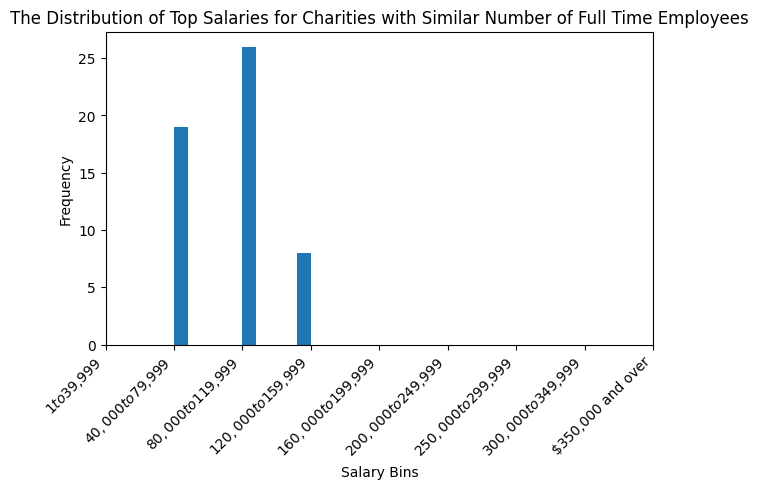

In [199]:
ax = revenue_employees["0.Top Salary Index"].dropna().astype(int).plot(kind="hist")
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels, rotation=45, ha='right')
plt.title("The Distribution of Top Salaries for Charities with Similar Number of Full Time Employees")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

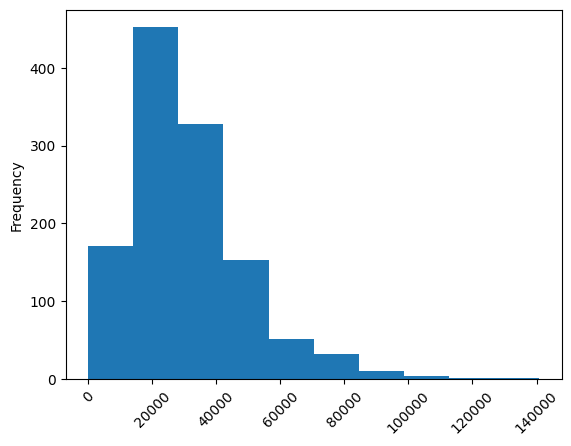

In [174]:
ax = revenue_employees["0.Average Salary"].plot(kind="hist", rot=45)

plt.show()

### Top Salaries for Each Similar DataFrame

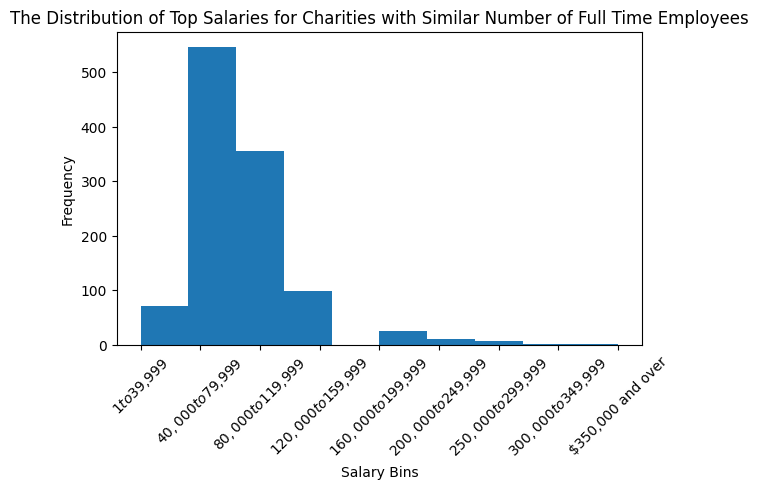

In [168]:
ax = similar_ft_employees["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with Similar Number of Full Time Employees")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

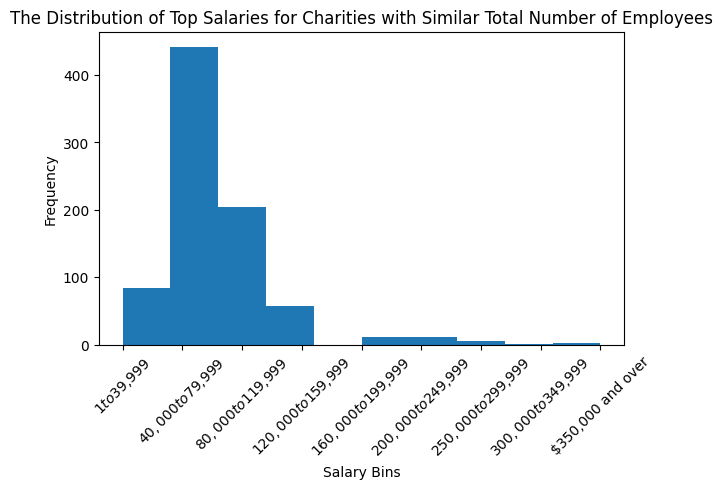

In [169]:
ax = similar_all_employees["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with Similar Total Number of Employees")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

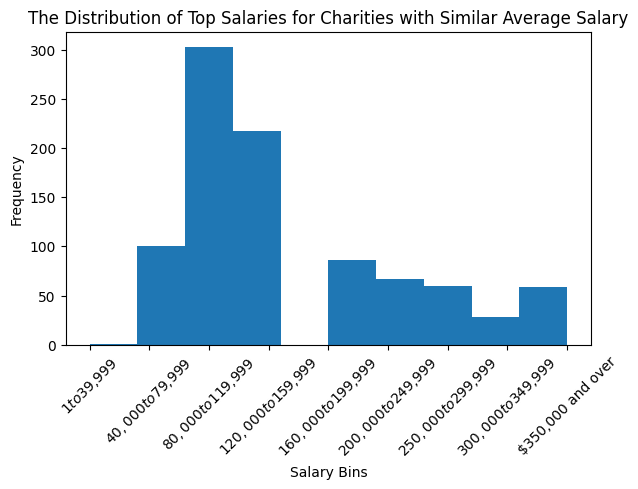

In [70]:
ax = similar_average_salary["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with Similar Average Salary")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

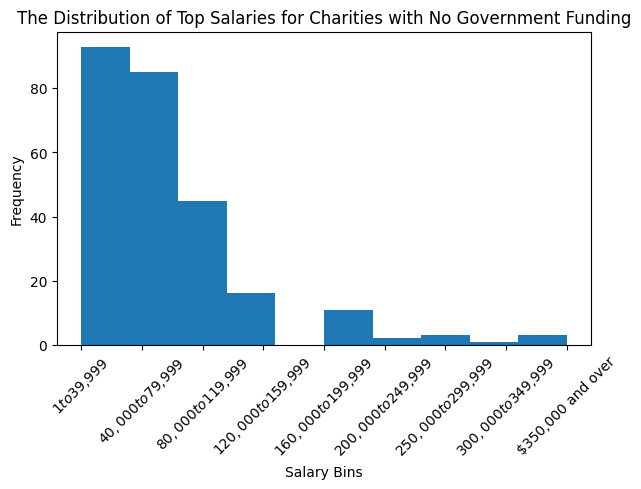

In [71]:
ax = similar_government_funding["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with No Government Funding")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

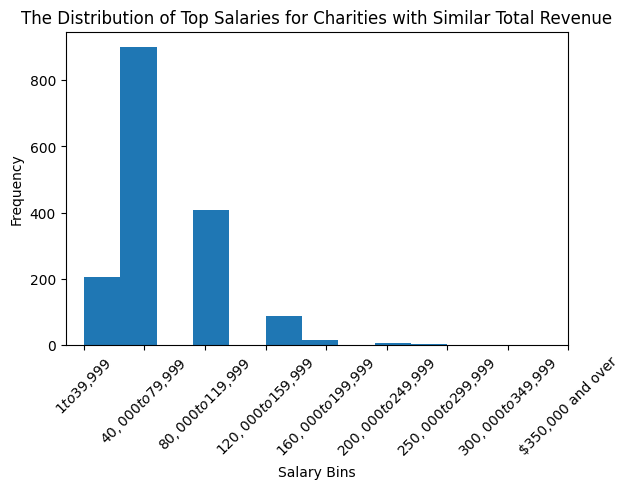

In [72]:
ax = similar_revenue["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with Similar Total Revenue")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

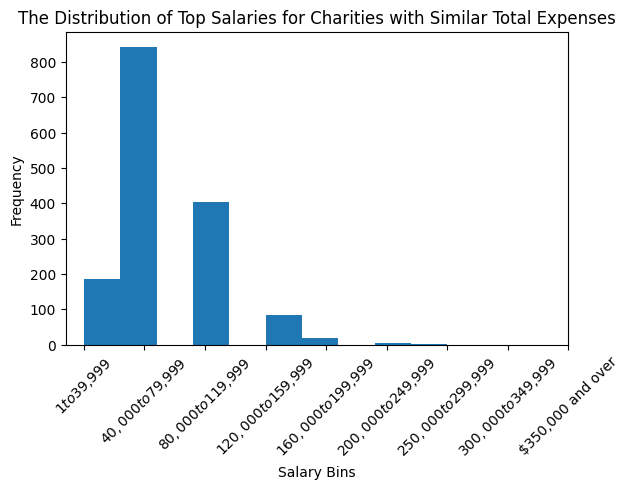

In [73]:
ax = similar_expenses["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with Similar Total Expenses")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

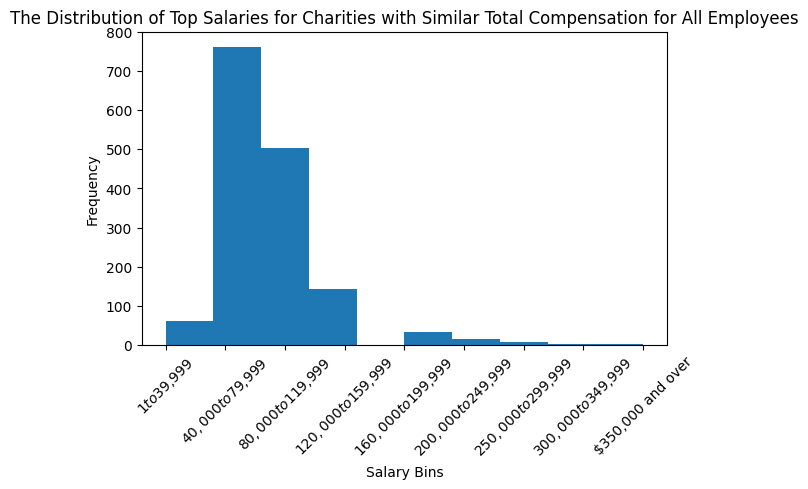

In [74]:
ax = similar_tot_comp_val["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities with Similar Total Compensation for All Employees")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

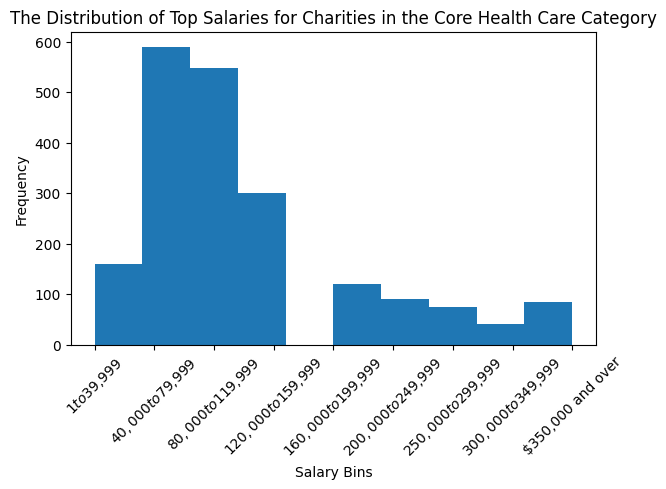

In [75]:
ax = same_category["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities in the Core Health Care Category")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

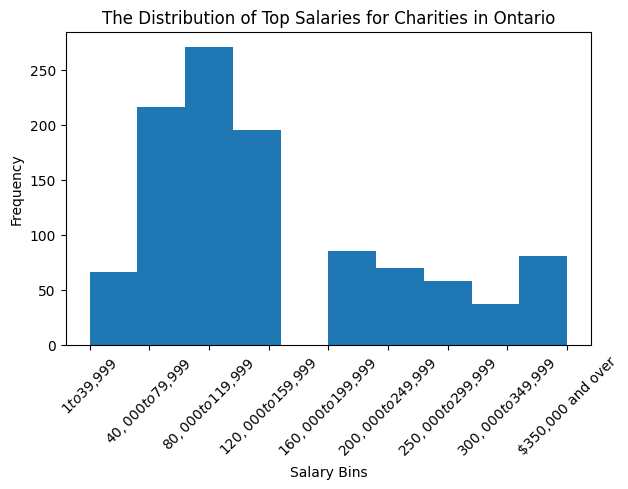

In [76]:
ax = same_province["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities in Ontario")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

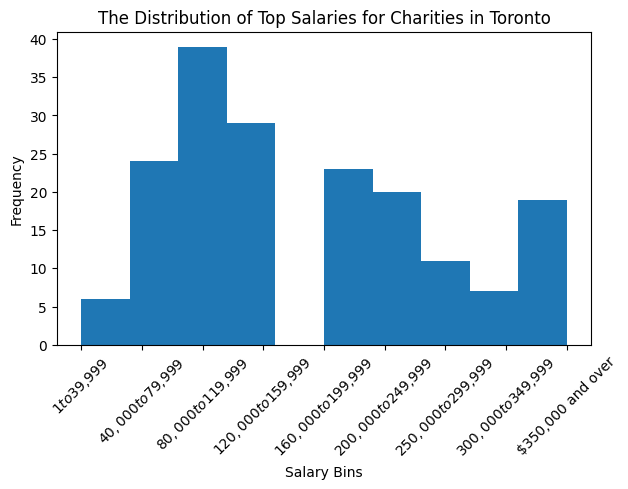

In [77]:
ax = same_city["0.Top Salary Index"].plot(kind="hist", rot=45)
ax.set_xticks(range(9))
ax.set_xticklabels(salary_bin_labels)
plt.title("The Distribution of Top Salaries for Charities in Toronto")
plt.tight_layout()
plt.xlabel("Salary Bins")
plt.show()

### Number of Employees in each Salary Bin (top 10 full time employees per charity)

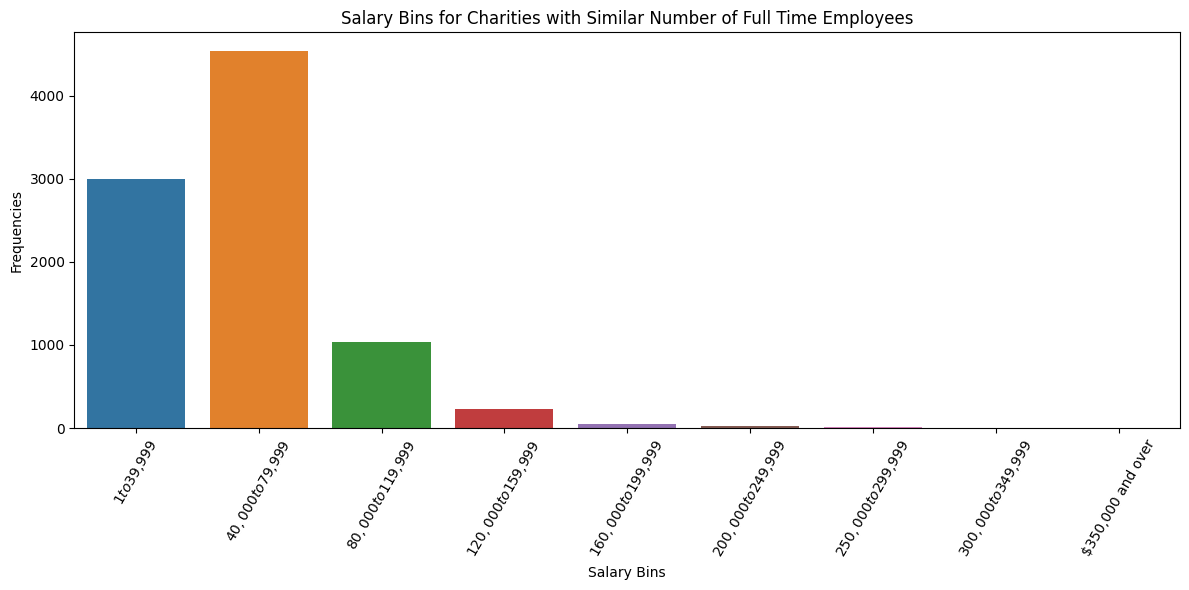

In [78]:
salary_list = salary_array_sum(similar_ft_employees, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("Salary Bins for Charities with Similar Number of Full Time Employees")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

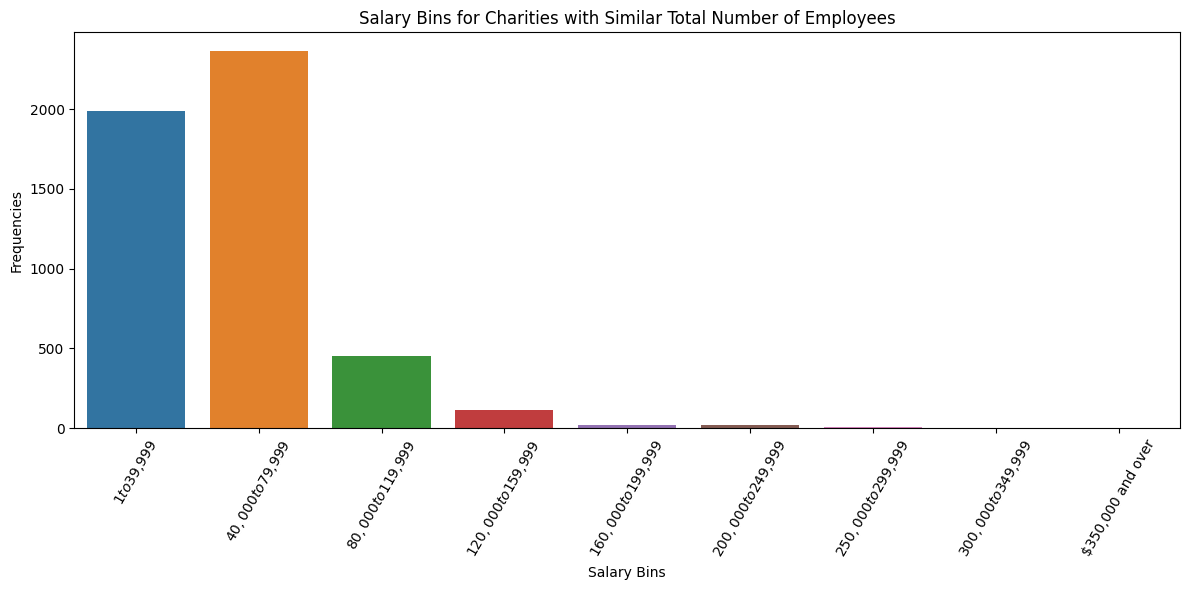

In [79]:
salary_list = salary_array_sum(similar_all_employees, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("Salary Bins for Charities with Similar Total Number of Employees")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

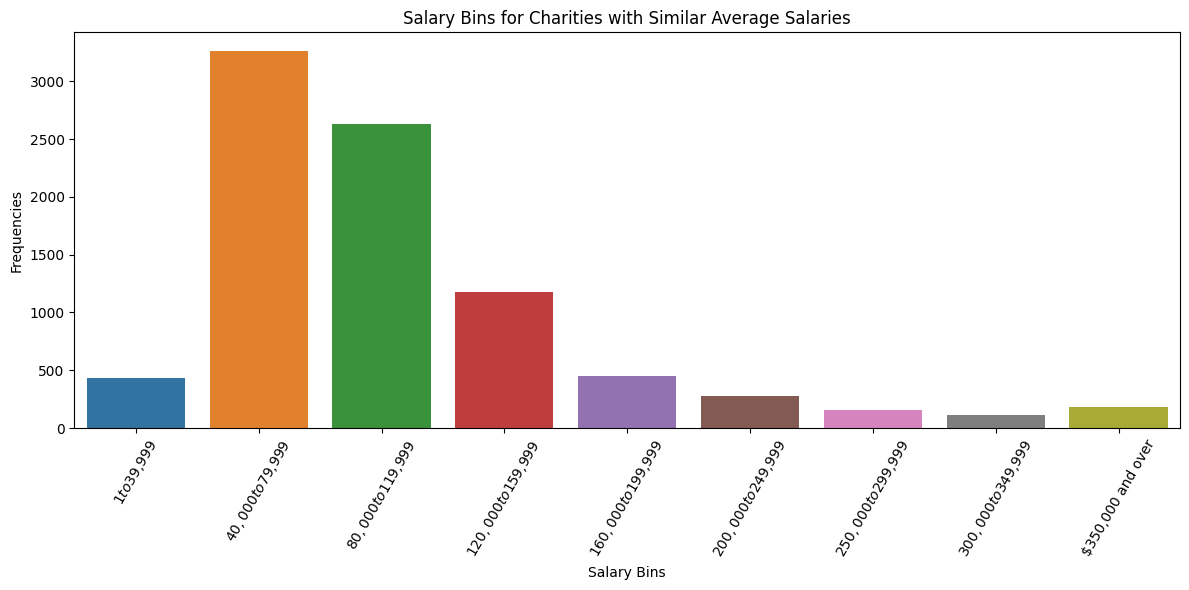

In [80]:
salary_list = salary_array_sum(similar_average_salary, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("Salary Bins for Charities with Similar Average Salaries")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

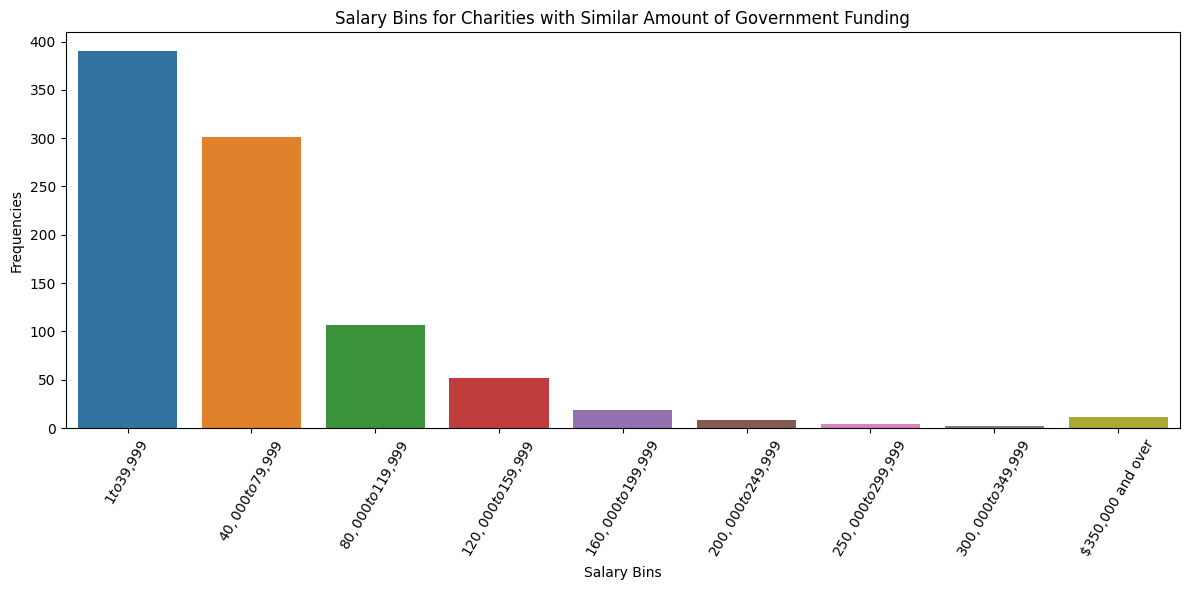

In [81]:
salary_list = salary_array_sum(similar_government_funding, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("Salary Bins for Charities with Similar Amount of Government Funding")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

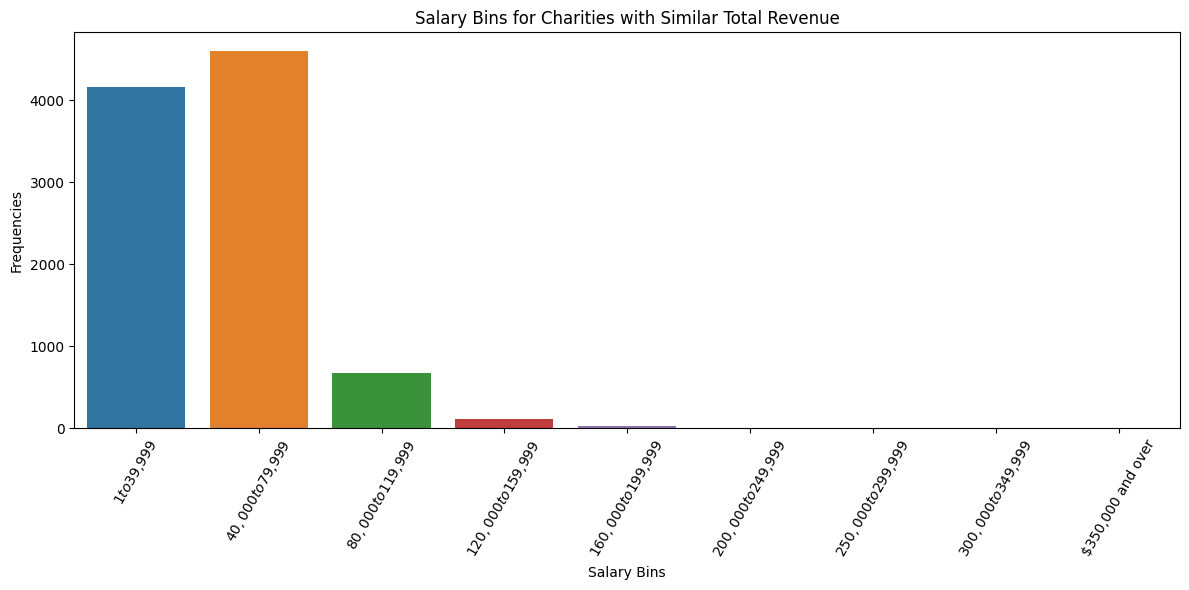

In [82]:
salary_list = salary_array_sum(similar_revenue, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("Salary Bins for Charities with Similar Total Revenue")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

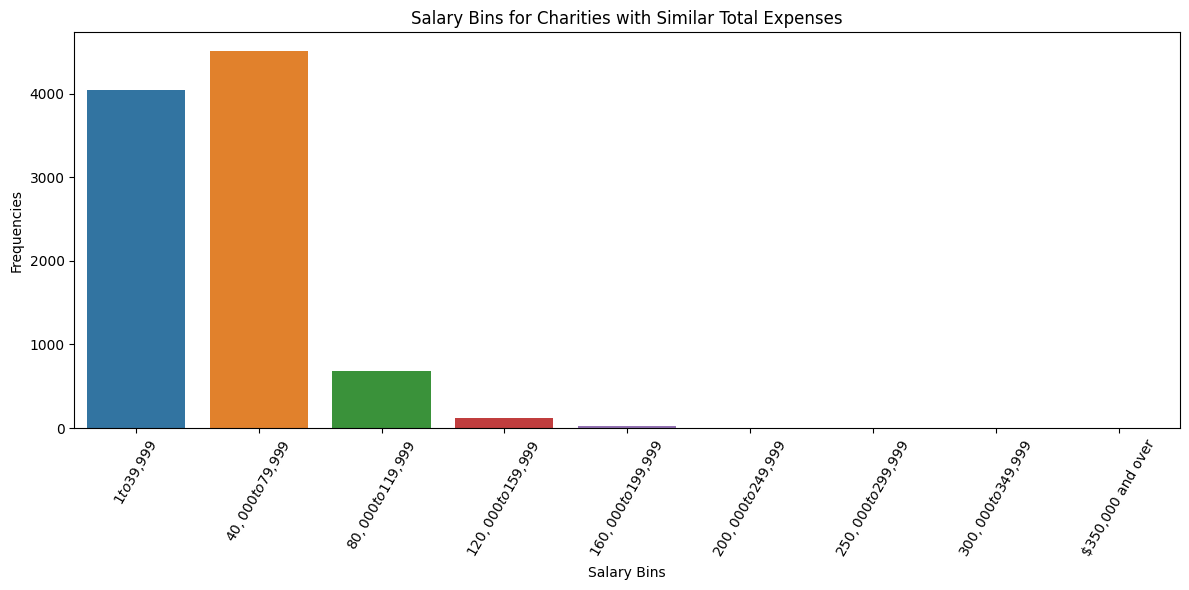

In [83]:
salary_list = salary_array_sum(similar_expenses, 0)

plt.figure(figsize=(12, 6))
chart = sns.barplot(x=salary_bin_labels, y=salary_list)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
plt.title("Salary Bins for Charities with Similar Total Expenses")
plt.xlabel("Salary Bins")
plt.ylabel("Frequencies")
plt.tight_layout()

### Exploring the Charities with Top Salaries of Less than 80k

In [90]:
low_top_salary = df[df["0.Top Salary Index"] < 2]

In [91]:
low_top_salary.shape

(1330, 88)

<AxesSubplot: ylabel='Frequency'>

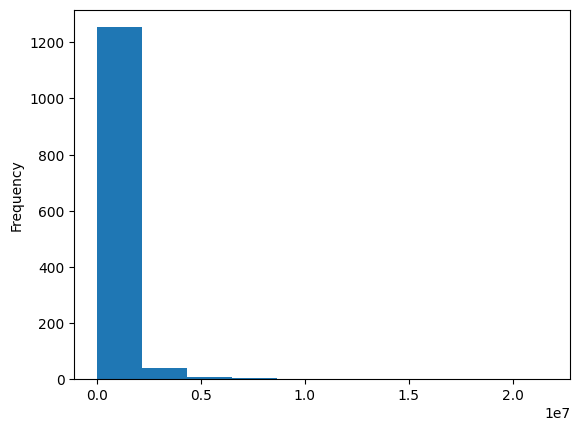

In [96]:
low_top_salary['0.Total Revenue'].plot(kind="hist")

In [95]:
low_top_salary[low_top_salary['0.Total Compensation Value'] > 3e6]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,province,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index
479,2263,106731987RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 49653...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tTHE CHARITY UNDERTAK...,"{'Receipted donations': 3715.0, 'Non-receipted...","{'Charitable programs': 5625203.0, 'Management...",{'Total compensation for all positions': 50624...,"{'$40,000 to $79,999': '10'}",...,MANITOBA,634958746f4326e0a00a70de,Health Care,148.0,33549.689189,81.720071,0.817201,6028497.0,0.992173,1.0
598,2845,118800879RR0001,2013-03-31,{'Total compensation for all positions': 42748...,"{'$1 to $39,999': '37', '$40,000 to $79,999': ...",Ongoing programs: \n\t\n\tBay Side Home operat...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': nan, 'Management and a...","{'Professional and consulting fees': nan, 'Tot...",NaN,...,NOVA SCOTIA,634959016f4326e0a00a73d7,Health Care,NaN,NaN,65.358259,0.653583,5290505.0,0.808866,1.0
812,3863,106813108RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 55282...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tPROVIDING RESIDENTIA...,"{'Receipted donations': 1885.0, 'Non-receipted...","{'Charitable programs': 5984941.0, 'Management...",{'Total compensation for all positions': 49806...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,63495b056f4326e0a00a7f60,Health Care,110.0,50256.381818,85.885656,0.858857,5705431.0,0.886391,1.0
1619,7717,119157741RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 37130...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tTHE ORGANIZATION IS ...,"{'Receipted donations': 12470.0, 'Non-receipte...","{'Charitable programs': nan, 'Management and a...",{'Total compensation for all positions': 36858...,{},...,ONTARIO,634962c0cd1ff4e263ac6849,Health Care,94.0,39500.872340,79.796175,0.797962,4332151.0,0.931003,1.0
1648,7862,107661050RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 36381...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tCOMMUNITY LIVING MAN...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 3844256.0, 'Management...",{'Total compensation for all positions': 25927...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,634962c4cd1ff4e263ac6868,Health Care,54.0,67372.611111,100.516324,1.005163,0.0,0.000000,1.0
1665,7947,106962889RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 51547...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tOVERSEE VARIOUS PROG...,"{'Receipted donations': 26490.0, 'Non-receipte...","{'Charitable programs': 6104671.0, 'Management...",{'Total compensation for all positions': 47943...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,634962c8cd1ff4e263ac687b,Health Care,146.0,35306.609589,76.359819,0.763598,6201992.0,0.918729,1.0
1675,7997,108188426RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 54609...,"{'$40,000 to $79,999': '30'}",Ongoing programs: \n\t\n\tSUPPORTED INDEPENDEN...,"{'Receipted donations': 10082.0, 'Non-receipte...","{'Charitable programs': 6524036.0, 'Management...",{'Total compensation for all positions': 24811...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,634962c8cd1ff4e263ac6886,Health Care,96.0,56885.000000,75.427520,0.754275,7201975.0,0.994747,1.0
1915,9144,817584329RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 55215...,"{'$1 to $39,999': '75', '$40,000 to $79,999': ...",Ongoing programs: \n

In [97]:
low_top_salary[low_top_salary['0.Total Revenue'] > 5e6]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,province,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index
479,2263,106731987RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 49653...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tTHE CHARITY UNDERTAK...,"{'Receipted donations': 3715.0, 'Non-receipted...","{'Charitable programs': 5625203.0, 'Management...",{'Total compensation for all positions': 50624...,"{'$40,000 to $79,999': '10'}",...,MANITOBA,634958746f4326e0a00a70de,Health Care,148.0,33549.689189,81.720071,0.817201,6028497.0,0.992173,1.0
598,2845,118800879RR0001,2013-03-31,{'Total compensation for all positions': 42748...,"{'$1 to $39,999': '37', '$40,000 to $79,999': ...",Ongoing programs: \n\t\n\tBay Side Home operat...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': nan, 'Management and a...","{'Professional and consulting fees': nan, 'Tot...",NaN,...,NOVA SCOTIA,634959016f4326e0a00a73d7,Health Care,NaN,NaN,65.358259,0.653583,5290505.0,0.808866,1.0
812,3863,106813108RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 55282...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tPROVIDING RESIDENTIA...,"{'Receipted donations': 1885.0, 'Non-receipted...","{'Charitable programs': 5984941.0, 'Management...",{'Total compensation for all positions': 49806...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,63495b056f4326e0a00a7f60,Health Care,110.0,50256.381818,85.885656,0.858857,5705431.0,0.886391,1.0
1665,7947,106962889RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 51547...,"{'$40,000 to $79,999': '10'}",Ongoing programs: \n\t\n\tOVERSEE VARIOUS PROG...,"{'Receipted donations': 26490.0, 'Non-receipte...","{'Charitable programs': 6104671.0, 'Management...",{'Total compensation for all positions': 47943...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,634962c8cd1ff4e263ac687b,Health Care,146.0,35306.609589,76.359819,0.763598,6201992.0,0.918729,1.0
1675,7997,108188426RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 54609...,"{'$40,000 to $79,999': '30'}",Ongoing programs: \n\t\n\tSUPPORTED INDEPENDEN...,"{'Receipted donations': 10082.0, 'Non-receipte...","{'Charitable programs': 6524036.0, 'Management...",{'Total compensation for all positions': 24811...,"{'$40,000 to $79,999': '10'}",...,ONTARIO,634962c8cd1ff4e263ac6886,Health Care,96.0,56885.000000,75.427520,0.754275,7201975.0,0.994747,1.0
1915,9144,817584329RR0001,2022-03-31\n2021-03-31\n2020-03-31\n2019-03-31...,{'Total compensation for all positions': 55215...,"{'$1 to $39,999': '75', '$40,000 to $79,999': ...",Ongoing programs: \n\t\n\tPROVIDE GROUP HOMES ...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 6945534.0, 'Management...",{'Total compensation for all positions': 56929...,"{'$1 to $39,999': '2', '$40,000 to $79,999': '...",...,SASKATCHEWAN,634964dccd1ff4e263ac7459,Health Care,210.0,26293.028571,74.649125,0.746491,4640533.0,0.627383,1.0
2203,10462,875397028RR0001,2021-09-30\n2020-09-30\n2019-09-30\n2018-09-30...,{'Total compensation for all positions': 35341...,"{'$1 to $39,999': '10'}",Ongoing programs: \n\t\n\tTO PROVIDE HOUSING F...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 1003443.0, 'Management...",{'Total compensation for all positions': 51365...,"{'$1 to $39,999': '10'}",...,BRITISH COLUMBIA,634969f1bbe078d684f1e12b,Health Care,32.0,11044.343750,2.770331,0.027703,0.0,0.000000,0.0
3656,17416,119040988RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 50293.

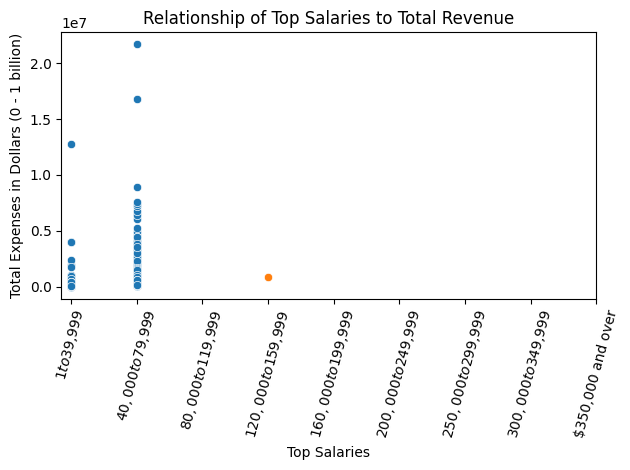

In [103]:
chart = sns.scatterplot(data=low_top_salary, x='0.Top Salary Index', y='0.Total Revenue')
draw_lcc(chart)
plt.title("Relationship of Top Salaries to Total Revenue")
plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
plt.xlabel("Top Salaries")
chart.set_xticks(range(9))
chart.set_xticklabels(salary_bin_labels, rotation=75)
plt.tight_layout()
plt.show()

<AxesSubplot: ylabel='Frequency'>

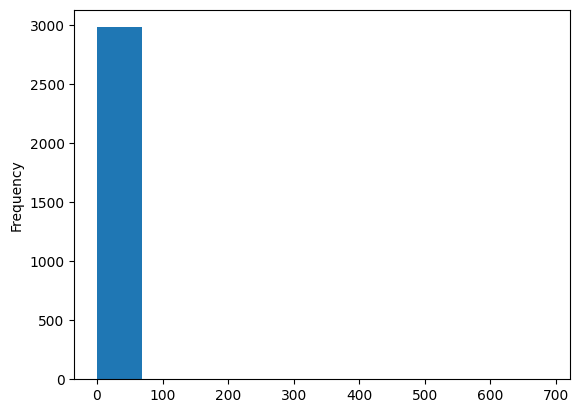

In [105]:
df["0.Ratio Compensation to Expenses"].plot(kind='hist')

<AxesSubplot: ylabel='Frequency'>

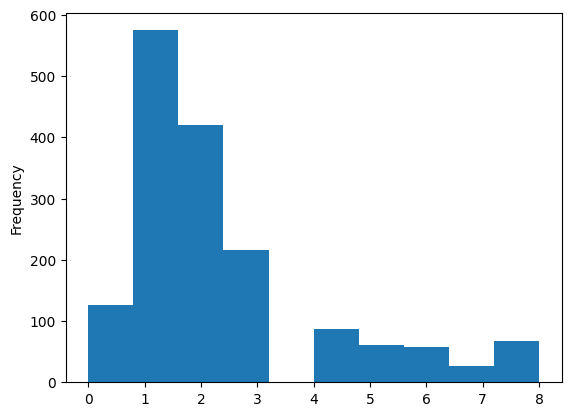

In [113]:
df[df["0.Ratio Compensation to Expenses"].between(0.5, 0.8)]["0.Top Salary Index"].plot(kind="hist")

In [112]:
lcc["0.Ratio Compensaiton"]

3403    0.490514
Name: 0.Ratio Revenue to Compensation, dtype: float64

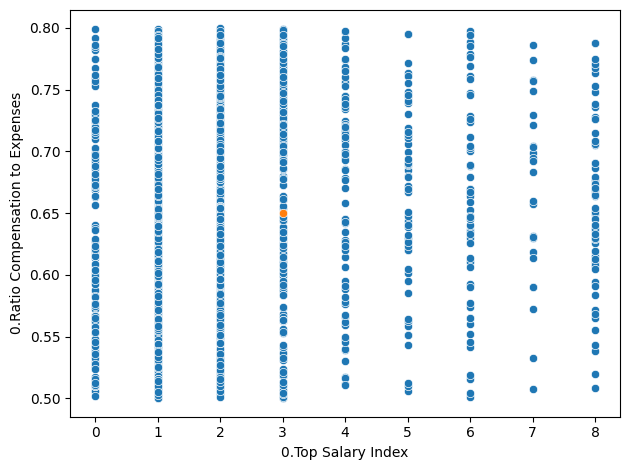

In [121]:
chart = sns.scatterplot(data=df[df["0.Ratio Compensation to Expenses"].between(0.5, 0.8)], x='0.Top Salary Index', y='0.Ratio Compensation to Expenses')
draw_lcc(chart)
#plt.title("Relationship of Top Salaries to Total Revenue")
#plt.ylabel("Total Expenses in Dollars (0 - 1 billion)")
#plt.xlabel("Top Salaries")
#chart.set_xticks(range(9))
#chart.set_xticklabels(salary_bin_labels, rotation=75)
plt.tight_layout()
plt.show()

In [116]:
df[df["0.Average Salary"] > 150000]

,Unnamed: 0_x,BN/Registration number,Reporting Period List,0.Total Compensation,0.Salary,0.Ongoing Programs,0.Revenue,0.Expenses,1.Total Compensation,1.Salary,...,_id,general_category,0.All Employees,0.Average Salary,0.Percent Revenue to Compensation,0.Ratio Revenue to Compensation,0.Government Funding,0.Ratio Government Funding to Total Revenue,0.Top Salary Index,0.Ratio Compensation to Expenses
5053,24018,139029839RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 58343...,"{'$80,000 to $119,999': '2', '$120,000 to $159...",Ongoing programs: \n\t\n\tPROVIDE OVERSIGHT AN...,"{'Receipted donations': 0.0, 'Non-receipted do...","{'Charitable programs': 0.0, 'Management and a...",{'Total compensation for all positions': 44571...,"{'$80,000 to $119,999': '1', '$120,000 to $159...",...,6349875c5e359e534e43b42e,Health Care,22.0,265196.590909,76.850433,0.768504,0.0,0.0000,8.0,0.725864
5605,26637,118964063RR0001,2021-03-31\n2020-03-31\n2019-03-31\n2018-03-31...,{'Total compensation for all positions': 18300...,"{'$80,000 to $119,999': '5', '$120,000 to $159...",Ongoing programs: \n\t\n\tWE OPERATE A COMPLEX...,"{'Receipted donations': 44504.0, 'Non-receipte...","{'Charitable programs': 23333658.0, 'Managemen...",{'Total compensation for all positions': 16303...,"{'$80,000 to $119,999': '7', '$120,000 to $159...",...,63498f075e359e534e43e0ed,Health Care,106.0,172645.245283,74.977249,0.749772,19314003.0,0.7913,4.0,0.774592
